# Biblioteca

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta, date

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


# sse = np.sum((model.fittedvalues - df.score)**2)

# Funcoes

In [303]:
def moving_average_test(series):
    serie = series.copy()

    error = pd.DataFrame(columns = ['n_window','RMSE'])

    for window in range(1, series.shape[0] -20):

        serie['media_movel_'+str(window)] = serie.Volume.rolling(window).mean()
        serie['media_movel_'+str(window)] = serie['media_movel_'+str(window)].fillna(0)

        # display(serie)

        error = pd.concat( [error ,
                            pd.DataFrame(   {   'n_window':window,
                                                'RMSE':mean_squared_error(serie.Volume,serie['media_movel_'+str(window)], squared = False)}, index= [0]
                                        )], ignore_index = True, axis = 0)

    return error


def moving_average_test2(series):
    serie = series.copy()

    error = pd.DataFrame(columns = ['n_window','RMSE'])

    for window in range(1, series.shape[0]):

        serie['media_movel_'+str(window)] = serie.Volume.rolling(window).mean()
        serie['media_movel_'+str(window)] = serie['media_movel_'+str(window)].fillna(0)

        # display(serie)

        error = pd.concat( [error ,
                            pd.DataFrame(   {   'n_window':window,
                                                'RMSE':mean_squared_error(serie.Volume,serie['media_movel_'+str(window)], squared = False)}, index= [0]
                                        )], ignore_index = True, axis = 0)

    return error


# Acessando arquivos


In [3]:
clusters = pd.read_excel('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/clusters_18medoids.xlsx')
dict_ = {}
for dic in range((clusters.shape[0])):
    # print(dic)
    dict_[clusters['clusters'][dic]] = clusters['medoids'][dic]
# dict_

In [4]:
# abrindo arquivos
viagens_validas = pd.read_excel('/Users/guilistocco/Documents/TCC 2 - Ônibus/BancoDados/Dados brutos/matriz_junho_mapeada.xlsx', index_col='Unnamed: 0')

#renomeia colunas
viagens_validas.columns = ['index_col', 'day', 'device_id', 'periodo', 'dataInicio', 'dataFim',
       'sequence', 'distance(m)', 'duration(s)', 'latitudeI', 'longitudeI',
       'latitudeF', 'longitudeF', 'Nome_PontoI', 'Nome_PontoF', 'PontoFinal',
       'dist_PontoF', 'PontoInicial', 'dist_PontoI']

# reordena colunas
viagens_validas = viagens_validas[[  'index_col', 'day', 'device_id', 'periodo', 'dataInicio', 'dataFim',
       'sequence', 'distance(m)', 'duration(s)', 'PontoInicial','Nome_PontoI','latitudeI', 'longitudeI','dist_PontoI',
       'PontoFinal','Nome_PontoF','latitudeF', 'longitudeF',  'dist_PontoF'  ]]

# ajusta numero do ponto ao dicionario de pontos 
viagens_validas['PontoInicial']    = viagens_validas['PontoInicial']    -1
viagens_validas['PontoFinal']      = viagens_validas['PontoFinal']      -1

viagens_validas['NEW_PontoInicial'] = viagens_validas['PontoInicial'].map(dict_)
viagens_validas['NEW_PontoFinal']   = viagens_validas['PontoFinal'].map(dict_)

viagens_validas['NEW_PontoInicial']  = viagens_validas['NEW_PontoInicial'].astype(int) 
viagens_validas['NEW_PontoFinal']    = viagens_validas['NEW_PontoFinal']  .astype(int) 

viagens_validas['day_of_week'] = viagens_validas.dataInicio.dt.day_of_week

# Volumes totais diarios

## Organizacao dos volumes por dia da serie (tirando 0)

In [100]:
start_date = date(2021,6,1)
end_date = date(2021,8,31)

volumes_totais_diarios = pd.DataFrame(columns = ['Volume'])

while start_date <= end_date:    
    volumes_totais_diarios = pd.concat([volumes_totais_diarios,
        
        pd.DataFrame(data= {'Volume':[viagens_validas.loc[viagens_validas['dataInicio'].dt.date == start_date].shape[0]]  })  ]  ,
                                                        axis = 0, ignore_index = True)
    start_date += timedelta(days=1)


volumes_totais_diarios.index = pd.date_range('2022-06-01', '2022-08-31')
volumes_totais_diarios.loc[:,'Volume'] = volumes_totais_diarios.loc[:,'Volume'].astype(int)

volumes_totais_diarios.reset_index(inplace=True)
volumes_totais_diarios.columns = ['Data', 'Volume']

## drop volumes vazios
volumes_totais_diarios = volumes_totais_diarios.loc[(volumes_totais_diarios['Volume'] != 0) &  (volumes_totais_diarios['Volume'] != 1)].reset_index(drop=True)


volumes_totais_diarios


Data  Volume
0  2022-06-01     139
1  2022-06-02     290
2  2022-06-07     241
3  2022-06-08     311
4  2022-06-09     291
..        ...     ...
58 2022-08-25     244
59 2022-08-26     290
60 2022-08-27     279
61 2022-08-30     221
62 2022-08-31     139

[63 rows x 2 columns]

In [101]:
print('Viagens por mes')
viagens_validas.dataInicio.dt.month.value_counts().sort_index()

Viagens por mes


6    4249
7    5071
8    5168
Name: dataInicio, dtype: int64

In [103]:
print('Dias por mes')
viagens_validas.groupby(pd.Grouper(key='dataInicio',freq = '1M')).agg({'day':'nunique'})


Dias por mes


day
dataInicio     
2021-06-30   20
2021-07-31   21
2021-08-31   23

In [107]:
X_train,X_test  = volumes_totais_diarios[['Data', 'Volume']][:41], volumes_totais_diarios[['Data', 'Volume']][41:]

X_train.shape, X_test.shape

((41, 2), (22, 2))

### Quantidade de viagens por dia

- essa eh a serie temporal
- tres meses: junho julho agosto
- so viagens validas
- os vazios sao finais de semana
- tem outros dias vazios e uma irregularidade "nao natural"
    - isso deve-se ao fato da viagens validas serem fruto de "hard breaks", simples cortes na base
- feriado de 9 de julho

<BarContainer object of 63 artists>

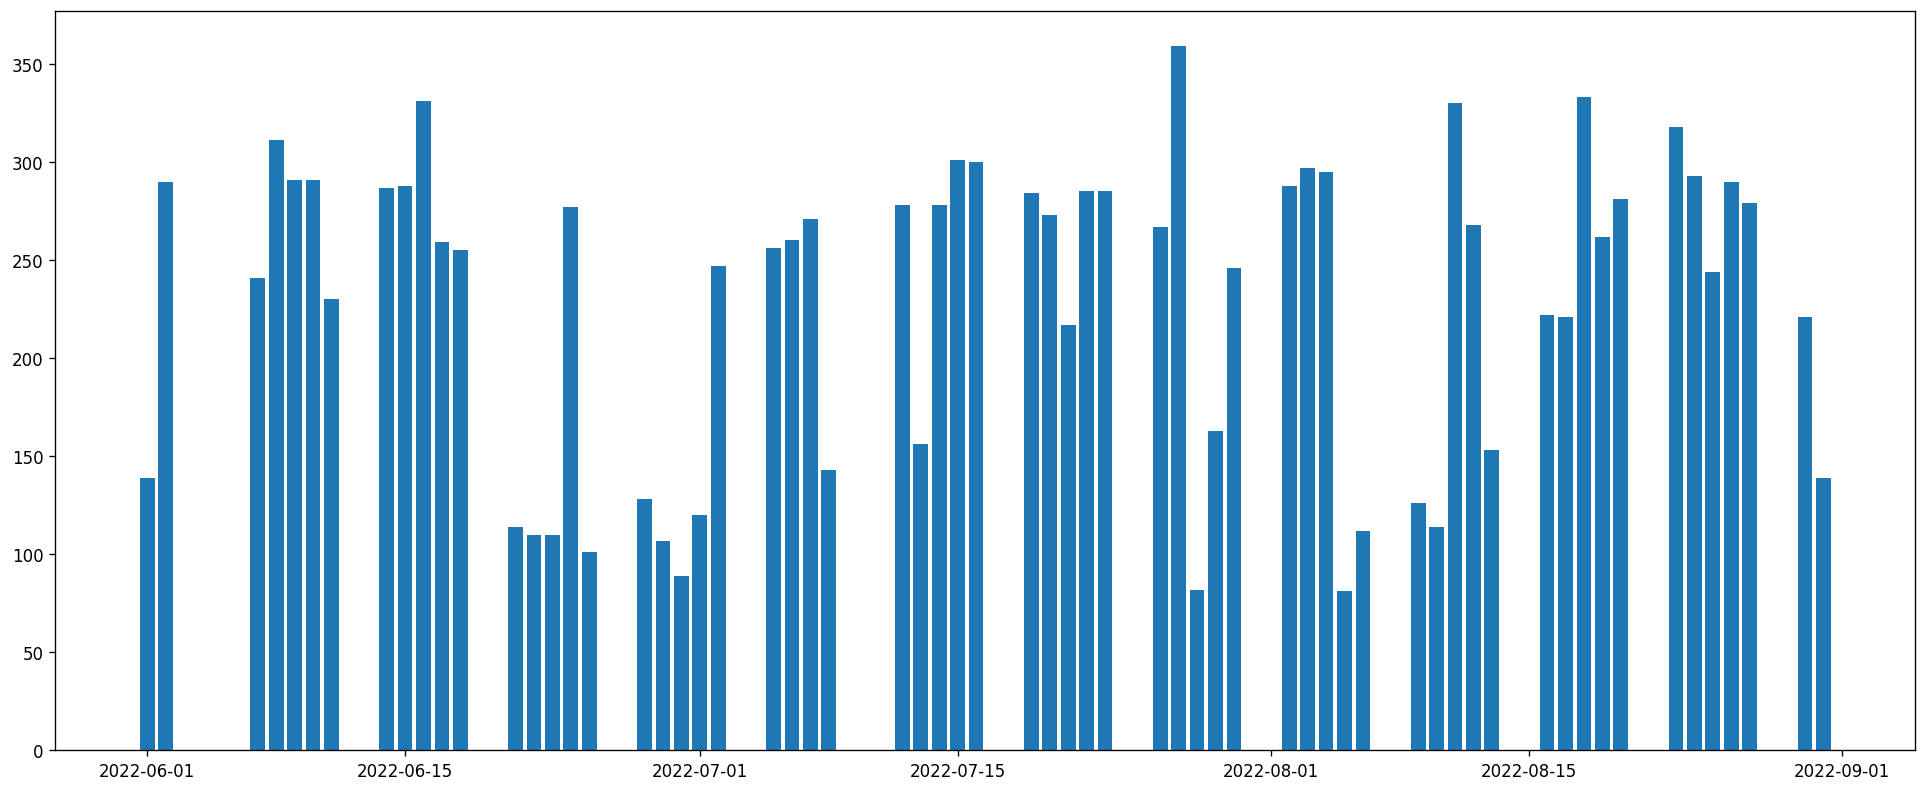

In [110]:
# volumes_totais_diarios['Volume'].plot(kind='bar', figsize = (15,8));
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(volumes_totais_diarios['Data'], volumes_totais_diarios['Volume'])

## Media Movel

### Escolhendo melhor numero de janela para a media movel (baseado no erro)

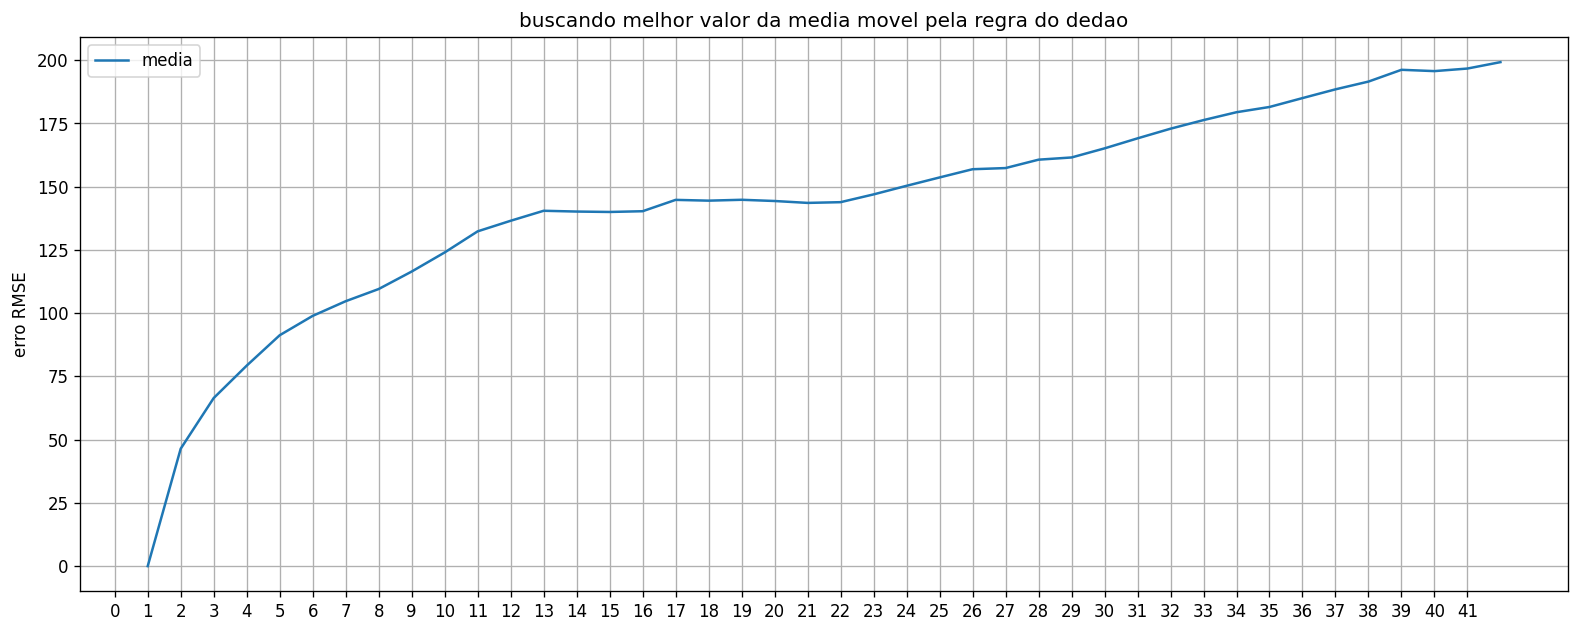

In [111]:
plt.rcParams["figure.figsize"] = (16,6)

erros_MA_diario = moving_average_test(volumes_totais_diarios)

plt.plot(erros_MA_diario.n_window, erros_MA_diario.RMSE)
plt.xticks([i for i in range(erros_MA_diario.shape[0])])
plt.legend(loc= 'best',labels = ['media', 'mediana'])
plt.ylabel('erro RMSE')
plt.title('buscando melhor valor da media movel pela regra do dedao')
plt.grid(visible=True, which = 'both')

plt.show()



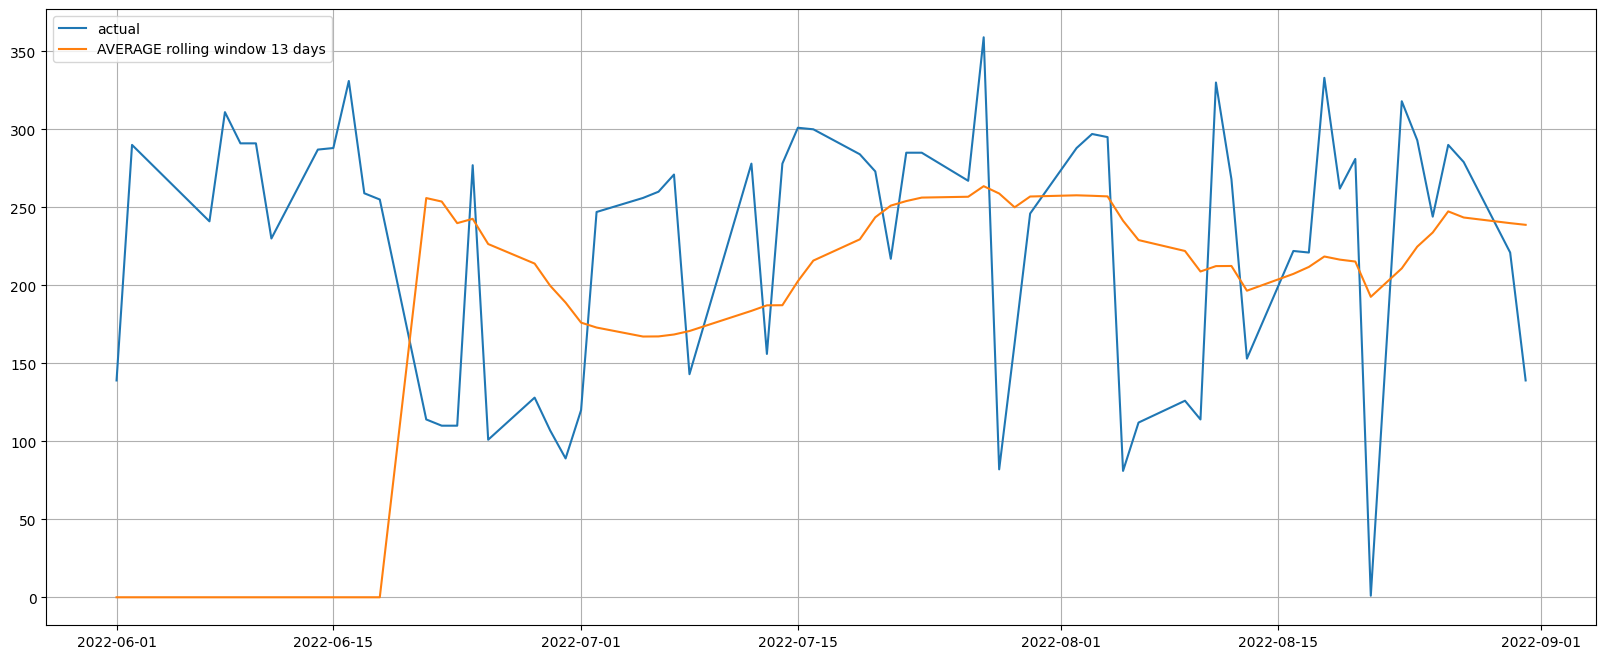

In [9]:
parametro = 13

volumes_totais_diarios['media_movel_' + str(parametro)] = volumes_totais_diarios['Volume'].rolling(parametro).mean().fillna(0)
plt.rcParams["figure.figsize"] = (20,8)

plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['Volume'])
plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['media_movel_' + str(parametro)])
plt.grid(visible=True)

# volumes_totais_diarios['mediana_movel_' + str(parametro)] = volumes_totais_diarios['Volume'].rolling(parametro).median()
# plt.plot(volumes_totais_diarios['Data'], volumes_totais_diarios['mediana_movel_' + str(parametro)], color = 'purple')

plt.legend(loc = 'upper left', labels = ['actual', 'AVERAGE rolling window {} days'.format(parametro), 'MEDIAN rolling window {} days'.format(parametro)])


plt.show()

### Modelagem Media Movel com step-by-step

In [168]:
results = list()
df_results_MA = pd.DataFrame()

for i in range(X_train.shape[0], volumes_totais_diarios.shape[0]+1):
    
    X = volumes_totais_diarios.iloc[:i]

    ### primeiro adiciona aos resultados os valores de treinamento
    ### Esse passo tambem determina o parameto de suavizacao para o step by step
    if i == X_train.shape[0]:
        MA_base = X['Volume'].rolling(13).mean().fillna(0)
        [results.append(MA_base.values[i]) for i in range(len(MA_base))]
    
    ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
    else:
        MA_base = X['Volume'].rolling(13).mean()
        results.append(MA_base.values[-1])

df_results_MA = pd.concat([X,pd.Series(results)], axis = 1, ignore_index = True)
df_results_MA.columns = ['Data', 'y_true', 'y_pred']
df_results_MA


Data  y_true      y_pred
0  2022-06-01     139    0.000000
1  2022-06-02     290    0.000000
2  2022-06-07     241    0.000000
3  2022-06-08     311    0.000000
4  2022-06-09     291    0.000000
..        ...     ...         ...
58 2022-08-25     244  243.461538
59 2022-08-26     290  256.076923
60 2022-08-27     279  268.769231
61 2022-08-30     221  260.384615
62 2022-08-31     139  250.461538

[63 rows x 3 columns]

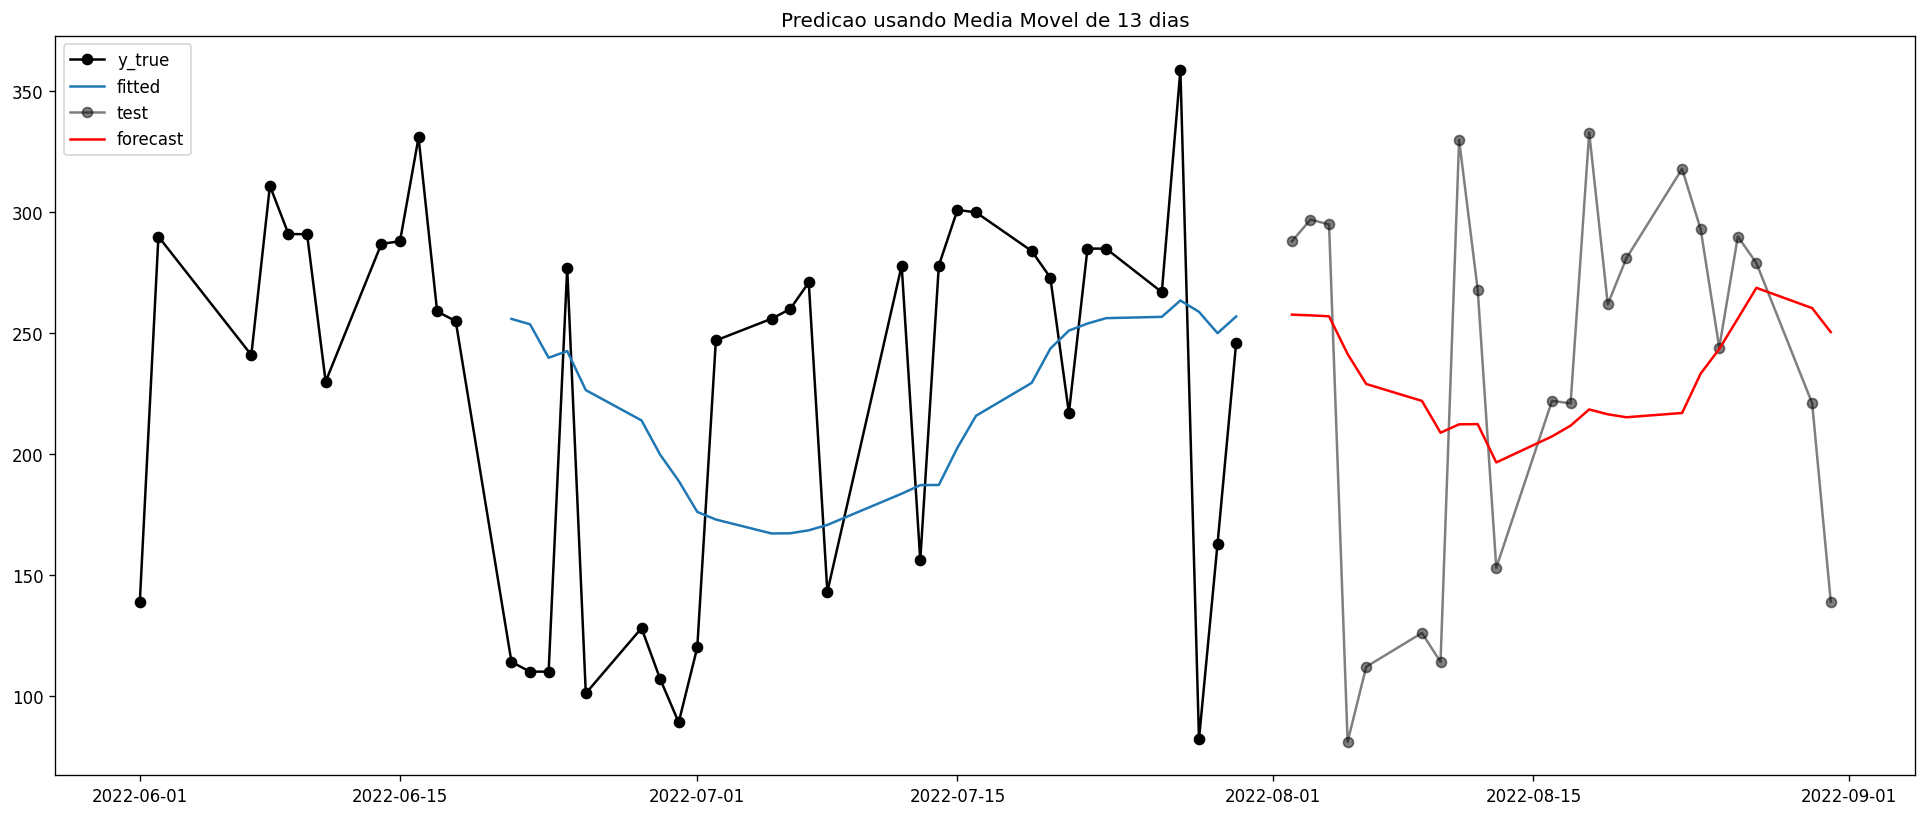

In [276]:
plt.rcParams["figure.figsize"] = (20,8)

# actual values
plt.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")

# result of trained values
plt.plot(X_train['Data'][12:41],df_results_MA['y_pred'][12:41])

# actual future values
plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)

# predicted values
plt.plot(X_test['Data'],df_results_MA['y_pred'][41:], color='red')

plt.legend(loc = 'upper left', labels = ['y_true', 'fitted', 'test', 'forecast'])
plt.title('Predicao usando Media Movel de 13 dias')

plt.show()

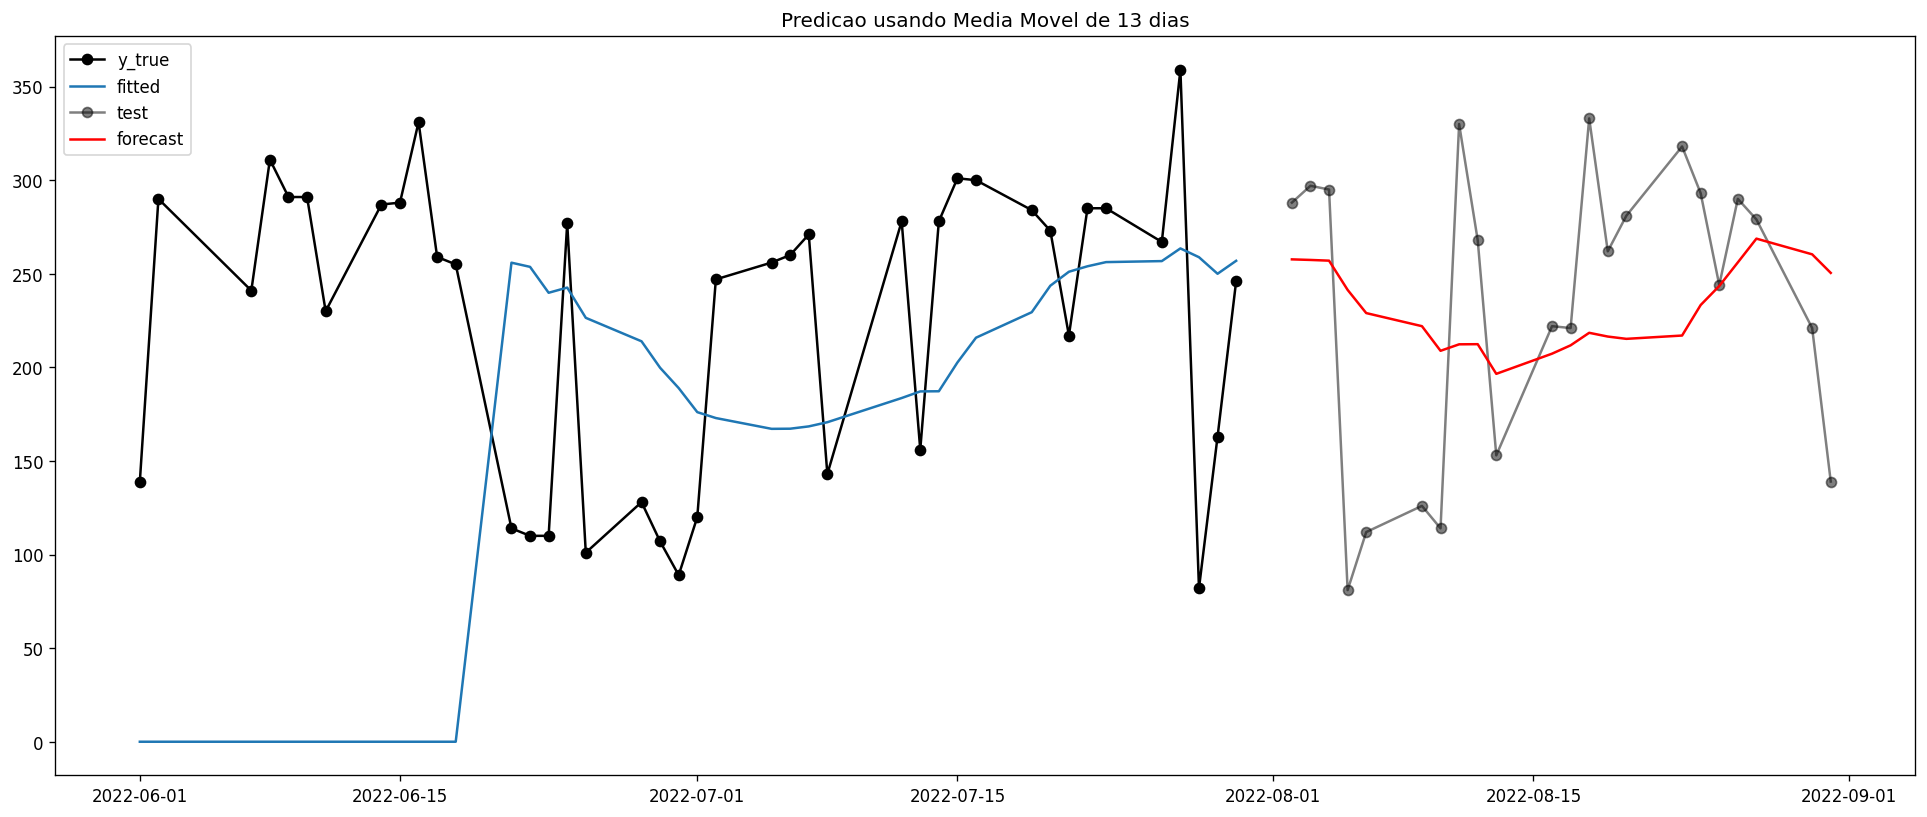

In [173]:
plt.rcParams["figure.figsize"] = (20,8)

# actual values
plt.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")

# result of trained values
plt.plot(X_train['Data'][:41],df_results_MA['y_pred'][:41])

# actual future values
plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)

# predicted values
plt.plot(X_test['Data'],df_results_MA['y_pred'][41:], color='red')

plt.legend(loc = 'upper left', labels = ['y_true', 'fitted', 'test', 'forecast'])
plt.title('Predicao usando Media Movel de 13 dias')

plt.show()

### calculo do erro

In [184]:
### tirando 0's

print('erro (RMSE) da modelagem \t',
         mean_squared_error(df_results_MA['y_true'][11:41],
                            df_results_MA['y_pred'][11:41],
                            squared=False))

print('erro (RMSE) da previsao \t',
         mean_squared_error(df_results_MA['y_true'][41:],
                            df_results_MA['y_pred'][41:],
                            squared=False))

erro (RMSE) da modelagem 	 98.62920419989474
erro (RMSE) da previsao 	 76.63677664955641


In [185]:
### com zeros iniciais

print('erro (RMSE) da modelagem \t',
         mean_squared_error(df_results_MA['y_true'][:41],
                            df_results_MA['y_pred'][:41],
                            squared=False))

print('erro (RMSE) da previsao \t',
         mean_squared_error(df_results_MA['y_true'][41:],
                            df_results_MA['y_pred'][41:],
                            squared=False))

erro (RMSE) da modelagem 	 164.85556114317947
erro (RMSE) da previsao 	 76.63677664955641


## Suavizacao Exponencial com step-by-step


[217.39111918 217.39111918 217.39111918 217.39111918 217.39111918
 217.39111918 217.39111918 217.39111918 217.39111918 217.39111918
 217.39111918 217.39111918 217.39111918 217.39111918 217.39111918
 217.39111918 217.39111918 217.39111918 217.39111918 217.39111918
 217.39111918 217.39111918 217.39111918]


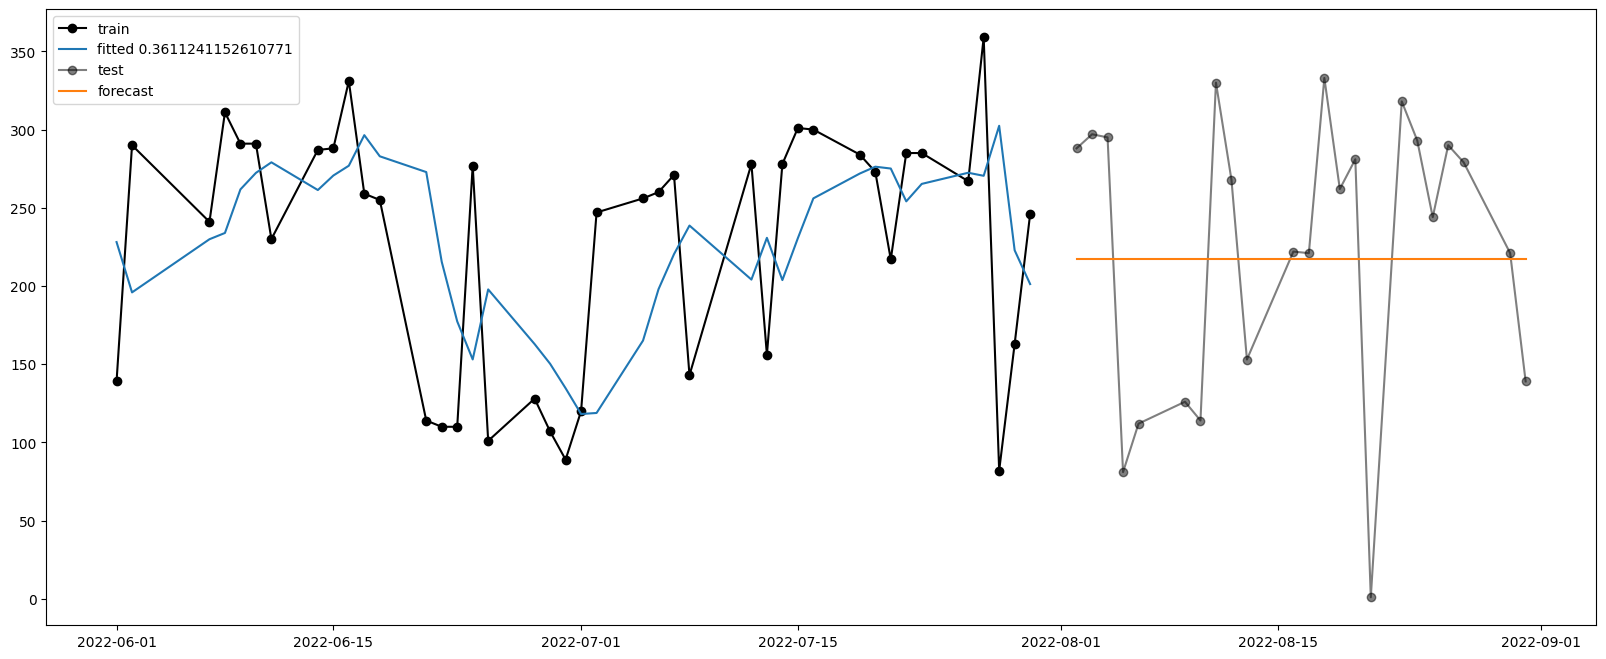

In [14]:
plt.figure(figsize=(20, 8))

fit1 = SimpleExpSmoothing(X_train['Volume'].values, initialization_method="heuristic").fit()

plt.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")
plt.plot(X_train['Data'],fit1.fittedvalues)
plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)
plt.plot(X_test['Data'],fit1.forecast(23))
print(fit1.forecast(23))

plt.legend(loc = 'upper left', labels = ['train', 'fitted {}'.format(fit1.model.params["smoothing_level"]), 'test', 'forecast'])

plt.show();

In [190]:
results = list()
df_results_SES = pd.DataFrame()

for i in range(X_train.shape[0], volumes_totais_diarios.shape[0]+1):
    
    X = volumes_totais_diarios.iloc[:i]

    ### primeiro adiciona aos resultados os valores de treinamento
    ### Esse passo tambem determina o parameto de suavizacao para o step by step
    if i == X_train.shape[0]:
        SES_base = SimpleExpSmoothing(X['Volume'].values, initialization_method="heuristic").fit()
        [results.append(SES_base.fittedvalues[i]) for i in range(len(SES_base.fittedvalues))]
    
    ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
    else:
        SES_step = SimpleExpSmoothing(X['Volume'].values, initialization_method="heuristic").fit(smoothing_level=SES_base.model.params["smoothing_level"])
        results.append(SES_step.fittedvalues[-1])

df_results_SES = pd.concat([X,pd.Series(results)], axis = 1, ignore_index = True)
df_results_SES.columns = ['Data', 'y_true', 'y_pred']
print('smoothing_level =',SES_base.model.params["smoothing_level"])
df_results_SES


smoothing_level =  0.3611241152610771


Data  y_true      y_pred
0  2022-06-01     139  228.086272
1  2022-06-02     290  195.915071
2  2022-06-07     241  229.891408
3  2022-06-08     311  233.902988
4  2022-06-09     291  261.744578
..        ...     ...         ...
58 2022-08-25     244  288.032849
59 2022-08-26     290  272.131525
60 2022-08-27     279  278.584262
61 2022-08-30     221  278.734395
62 2022-08-31     139  257.885113

[63 rows x 3 columns]

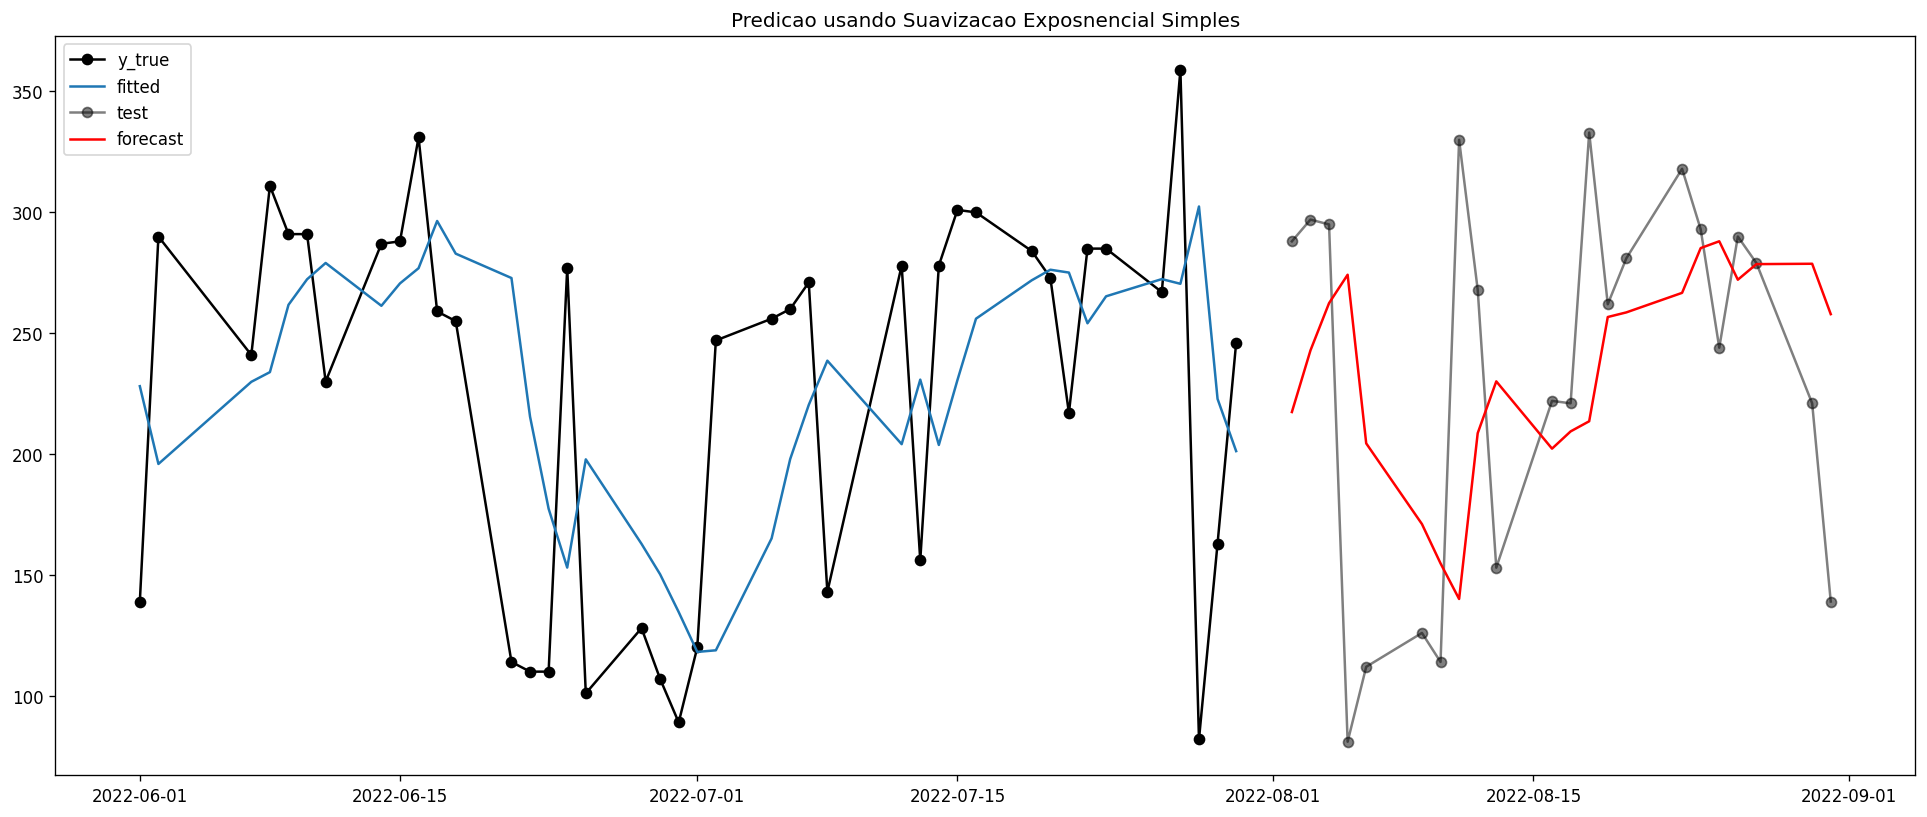

In [277]:
plt.figure(figsize=(20, 8))

######## y_pred[:41] deve ser igual ao fit1.fittedvalues E O FATO SE CONFIRMA COM O CODIGO ABAIXO

# fit1 = SimpleExpSmoothing(X_train['Volume'].values, initialization_method="heuristic").fit()
# plt.plot(X_train['Data'],fit1.fittedvalues, color = 'pink')


plt.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")

plt.plot(X_train['Data'],df_results_SES['y_pred'][:41])

plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)

plt.plot(X_test['Data'],df_results_SES['y_pred'][41:], color='red')

plt.legend(loc = 'upper left', labels = ['y_true', 'fitted', 'test', 'forecast'])
plt.title('Predicao usando Suavizacao Exposnencial Simples')


plt.show();

### calculo do erro

In [191]:
print('erro (RMSE) da modelagem \t',
         mean_squared_error(df_results_SES['y_true'][:41],
                            df_results_SES['y_pred'][:41],
                            squared=False))

print('erro (RMSE) da previsao \t',
         mean_squared_error(df_results_SES['y_true'][41:],
                            df_results_SES['y_pred'][41:],
                            squared=False))

erro (RMSE) da modelagem 	 75.54146414596443
erro (RMSE) da previsao 	 80.28649154200895


In [192]:
### MEDIA PERFORMA MELHOR QUE SUAVIZACAO EXPONENCIAL MAIS APURADA

mean_squared_error(X_test['Volume'],np.array([volumes_totais_diarios['Volume'].mean() for i in range(X_test.shape[0])]),squared=False)


77.02102439145838

## Metodo de Holt

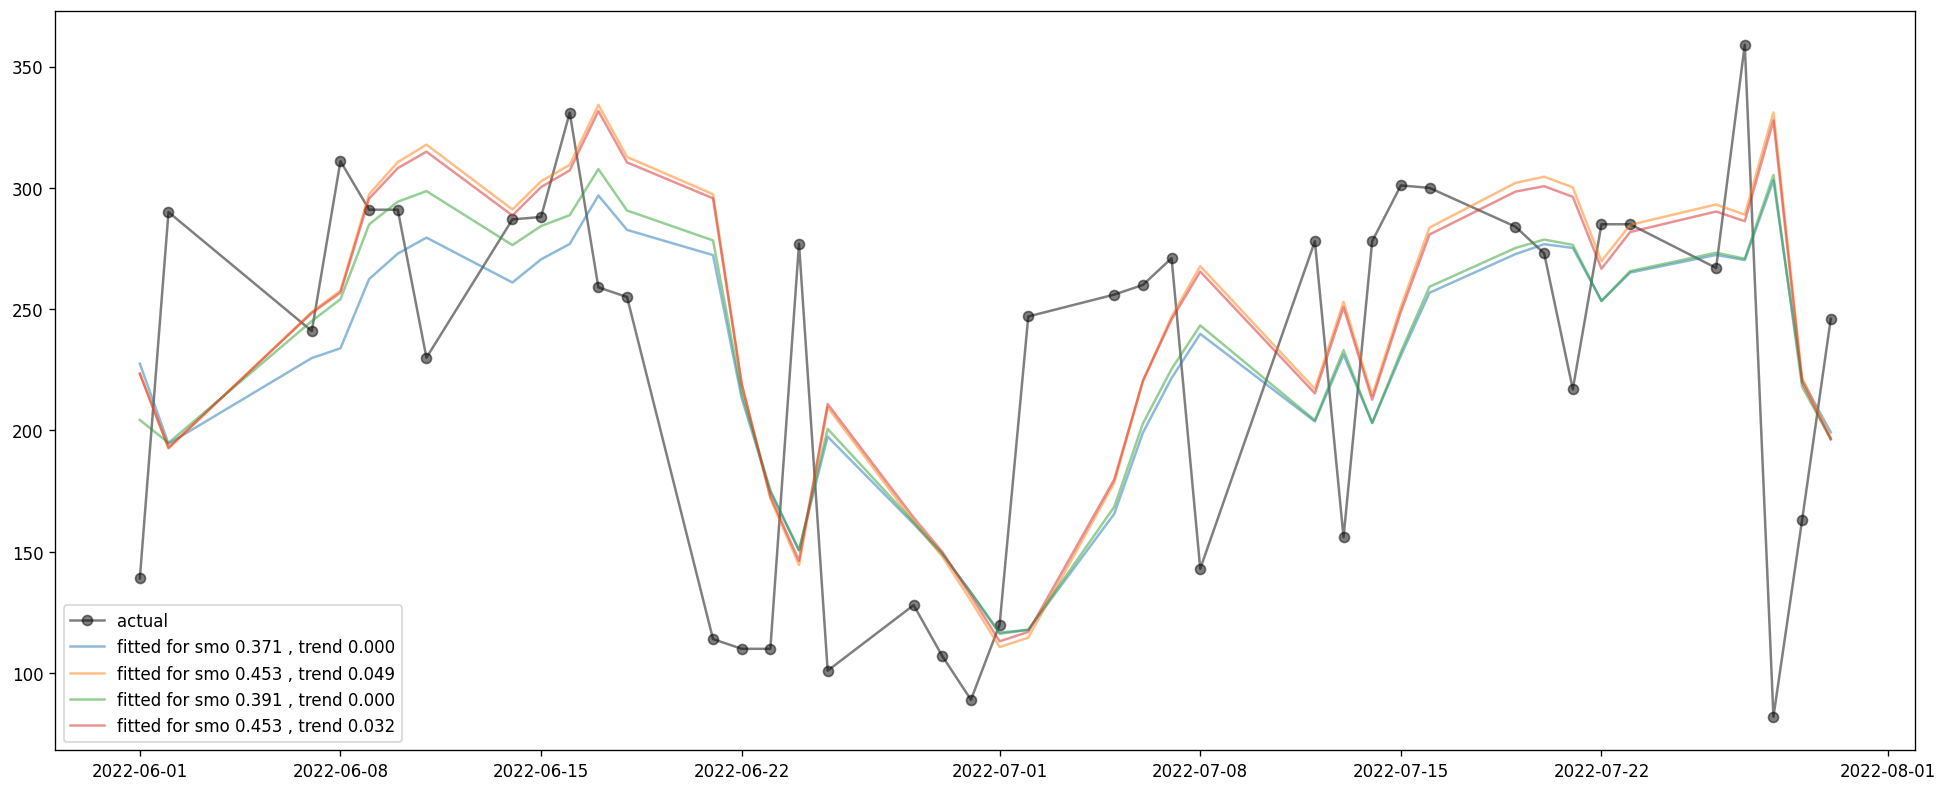

In [193]:
plt.figure(figsize=(20, 8))

fit_holts1 = Holt(X_train['Volume'].values, initialization_method="estimated").fit(optimized=True)

fit_holts2 = Holt(X_train['Volume'].values, exponential=True, initialization_method="estimated").fit(optimized=True)

fit_holts3 = Holt(X_train['Volume'].values, damped_trend=True, initialization_method="estimated").fit(optimized=True)

fit_holts4 = Holt(X_train['Volume'].values,exponential=True, damped_trend=True, initialization_method="estimated").fit(optimized=True)

plt.plot(X_train['Data'],X_train['Volume'].values, marker="o", color="black", alpha = 0.5)

plt.plot(X_train['Data'],fit_holts1.fittedvalues,   alpha = 0.5)
plt.plot(X_train['Data'],fit_holts2.fittedvalues,   alpha = 0.5)
plt.plot(X_train['Data'],fit_holts3.fittedvalues,   alpha = 0.5)
plt.plot(X_train['Data'],fit_holts4.fittedvalues,   alpha = 0.5)

plt.legend(loc = 'lower left', labels = ['actual', 
                                'fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts1.model.params["smoothing_level"], fit_holts1.model.params["smoothing_trend"]),
                                'fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts2.model.params["smoothing_level"], fit_holts2.model.params["smoothing_trend"]),
                                'fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts3.model.params["smoothing_level"], fit_holts3.model.params["smoothing_trend"]),
                                'fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts4.model.params["smoothing_level"], fit_holts4.model.params["smoothing_trend"])
                                
                                ])

plt.title('Escolha do modelo de Holt')

plt.show();

In [278]:
print('exponential, Type of trend component.', end= '\n')
print('damped_trend, Should the trend component be damped.', end= '\n')
print()
print('erro (RMSE) da modelagem (fit otimizado = otimos / sem parametros)\t', mean_squared_error(X_train['Volume'],fit_holts1.fittedvalues, squared=False))
print('erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True)\t', mean_squared_error(X_train['Volume'],fit_holts2.fittedvalues, squared=False))
print('erro (RMSE) da modelagem (fit otimizado = otimos / damped_trend=True)\t', mean_squared_error(X_train['Volume'],fit_holts3.fittedvalues, squared=False))
print('erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True e damped_trend=True)\t', mean_squared_error(X_train['Volume'],fit_holts4.fittedvalues, squared=False))


print('\n ------> a melhor modelagem eh (fit otimizado = otimos / damped_trend=True)' )
 

exponential, Type of trend component.
damped_trend, Should the trend component be damped.

erro (RMSE) da modelagem (fit otimizado = otimos / sem parametros)	 75.54369280073026
erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True)	 80.23092596189554
erro (RMSE) da modelagem (fit otimizado = otimos / damped_trend=True)	 75.12564422984332
erro (RMSE) da modelagem (fit otimizado = otimos / exponential=True e damped_trend=True)	 79.46778300635756

 ------> a melhor modelagem eh (fit otimizado = otimos / damped_trend=True)


[215.84316727 215.83677142 215.83158247 215.82737266 215.82395724
 215.8211863  215.81893824 215.81711438 215.81563468 215.81443419
 215.81346024 215.81267007 215.81202901 215.81150891 215.81108695
 215.81074462 215.81046688 215.81024155 215.81005875 215.80991043
 215.80979011 215.80969249]


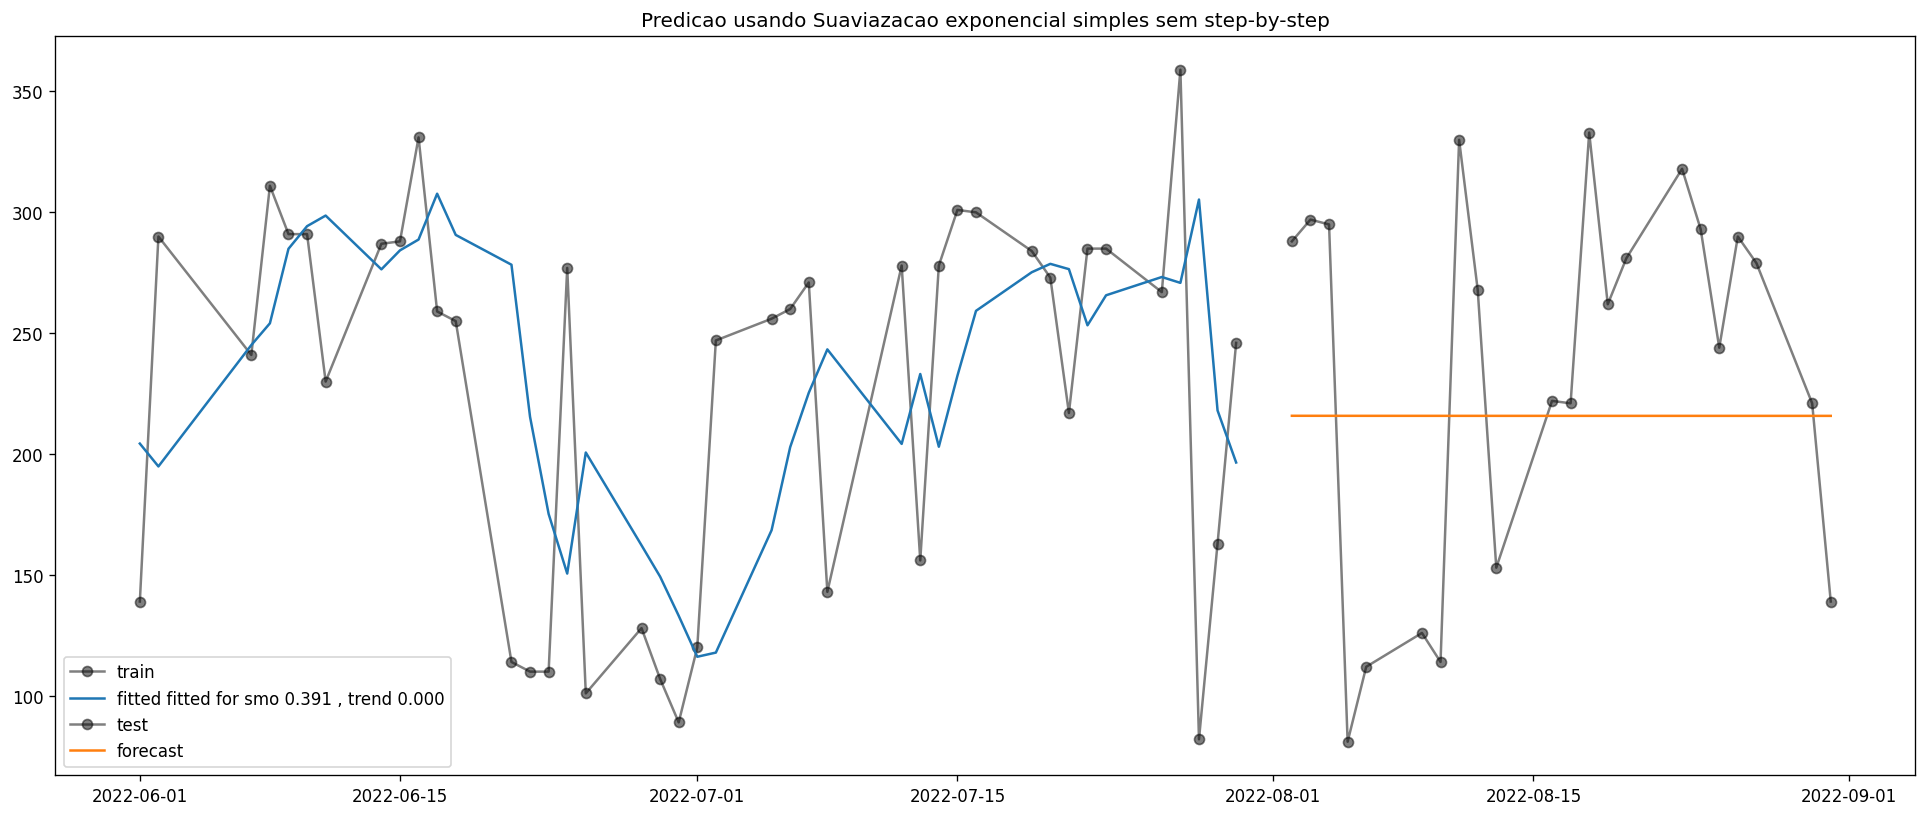

In [279]:
plt.figure(figsize=(20, 8))

fit_holts_final = Holt(X_train['Volume'].values, damped_trend=True, initialization_method="estimated").fit(optimized=True)

plt.plot(X_train['Data'],X_train['Volume'].values, marker="o", color="black", alpha = 0.5)
plt.plot(X_train['Data'],fit_holts_final.fittedvalues)
plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)
plt.plot(X_test['Data'],fit_holts_final.forecast(22))
print(fit_holts_final.forecast(22))

plt.legend(loc = 'lower left', labels = ['train',
                    'fitted {}'.format('fitted for smo {:.3f} , trend {:.3f}'.format(fit_holts_final.model.params["smoothing_level"], fit_holts_final.model.params["smoothing_trend"])),
                    'test', 'forecast'])

plt.title('Predicao usando Suaviazacao exponencial simples sem step-by-step')

plt.show();


In [197]:
results = list()
df_results_SEH = pd.DataFrame()

for i in range(X_train.shape[0], volumes_totais_diarios.shape[0]+1):
    
    X = volumes_totais_diarios.iloc[:i]

    ### primeiro adiciona aos resultados os valores de treinamento
    ### Esse passo tambem determina o parameto de suavizacao para o step by step
    if i == X_train.shape[0]:
        SEH_base = Holt(X['Volume'].values, damped_trend=True, initialization_method="estimated").fit()
        [results.append(SEH_base.fittedvalues[i]) for i in range(len(SEH_base.fittedvalues))]
    
    ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
    else:
        SEH_step = Holt(X['Volume'].values, damped_trend=True, initialization_method="estimated").fit(smoothing_level = SEH_base.model.params["smoothing_level"],
                                                                                                      smoothing_trend = SEH_base.model.params["smoothing_trend"]  )
        results.append(SEH_step.fittedvalues[-1])

df_results_SEH = pd.concat([X,pd.Series(results)], axis = 1, ignore_index = True)
df_results_SEH.columns = ['Data', 'y_true', 'y_pred']
print('smoothing_level =',SEH_base.model.params["smoothing_level"])
print('smoothing_trend =',SEH_base.model.params["smoothing_trend"])
df_results_SEH


smoothing_level = 0.39070768848951115
smoothing_trend = 0.00047258699411787975


Data  y_true      y_pred
0  2022-06-01     139  204.342813
1  2022-06-02     290  194.891503
2  2022-06-07     241  245.109988
3  2022-06-08     311  254.098244
4  2022-06-09     291  284.933698
..        ...     ...         ...
58 2022-08-25     244  291.748919
59 2022-08-26     290  273.971567
60 2022-08-27     279  280.956831
61 2022-08-30     221  280.181379
62 2022-08-31     139  256.051682

[63 rows x 3 columns]

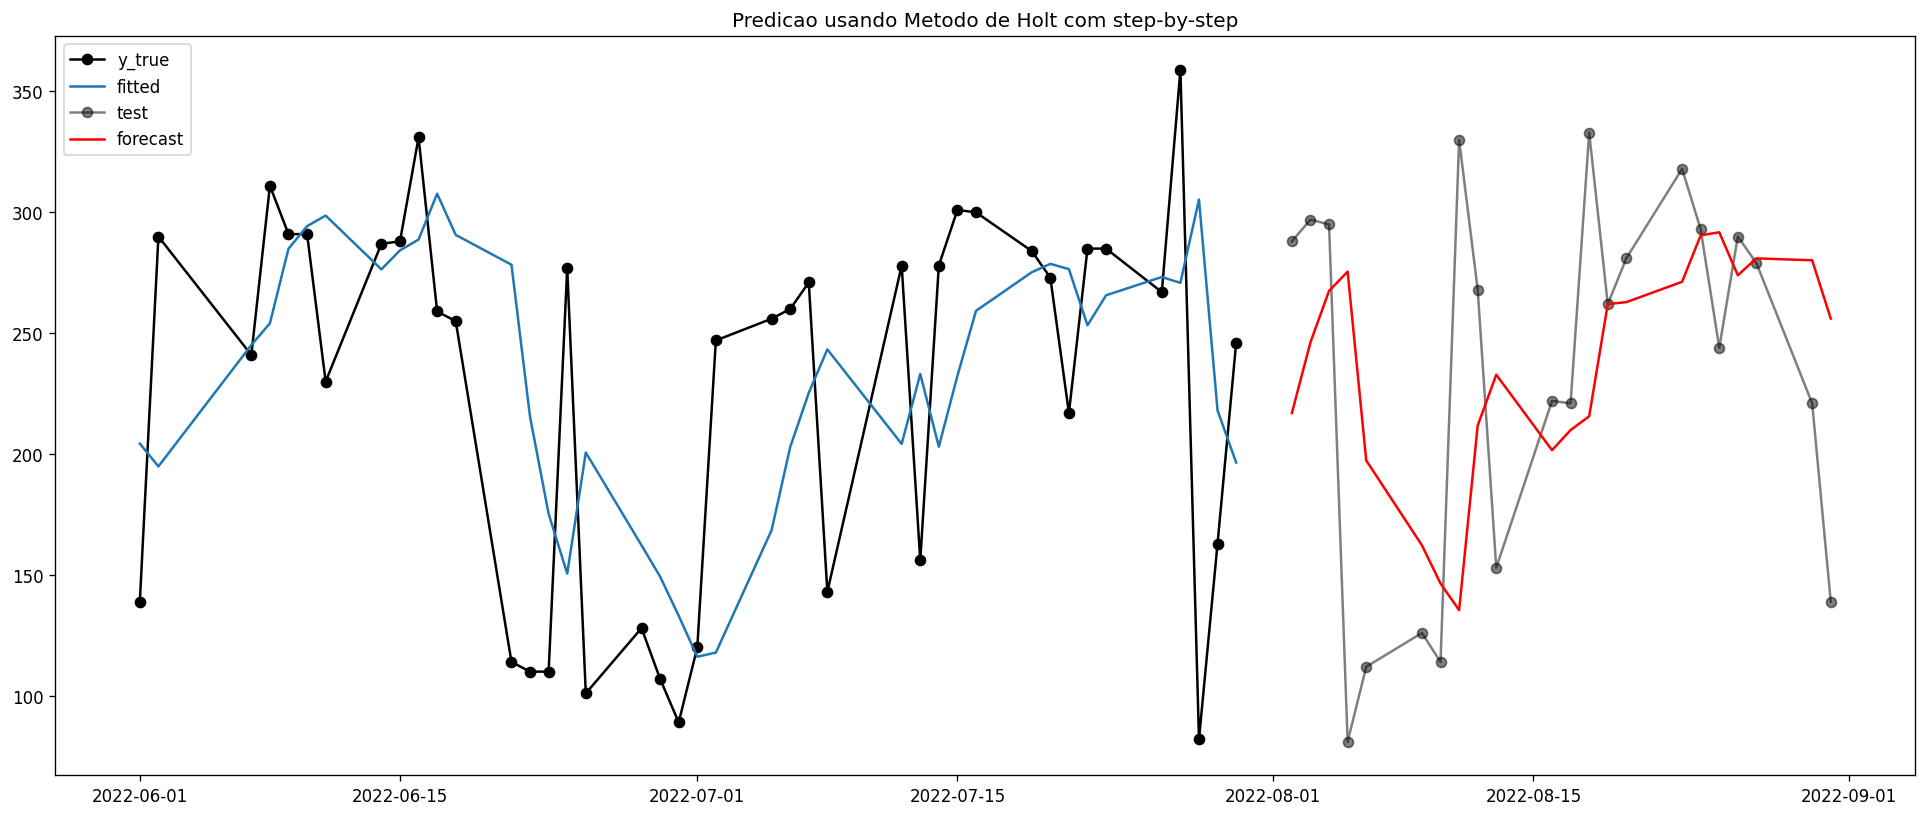

In [280]:
plt.figure(figsize=(20, 8))

plt.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")

plt.plot(X_train['Data'],df_results_SEH['y_pred'][:41])

plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)

plt.plot(X_test['Data'],df_results_SEH['y_pred'][41:], color='red')

plt.legend(loc = 'upper left', labels = ['y_true', 'fitted', 'test', 'forecast'])

plt.title('Predicao usando Metodo de Holt com step-by-step')

plt.show();

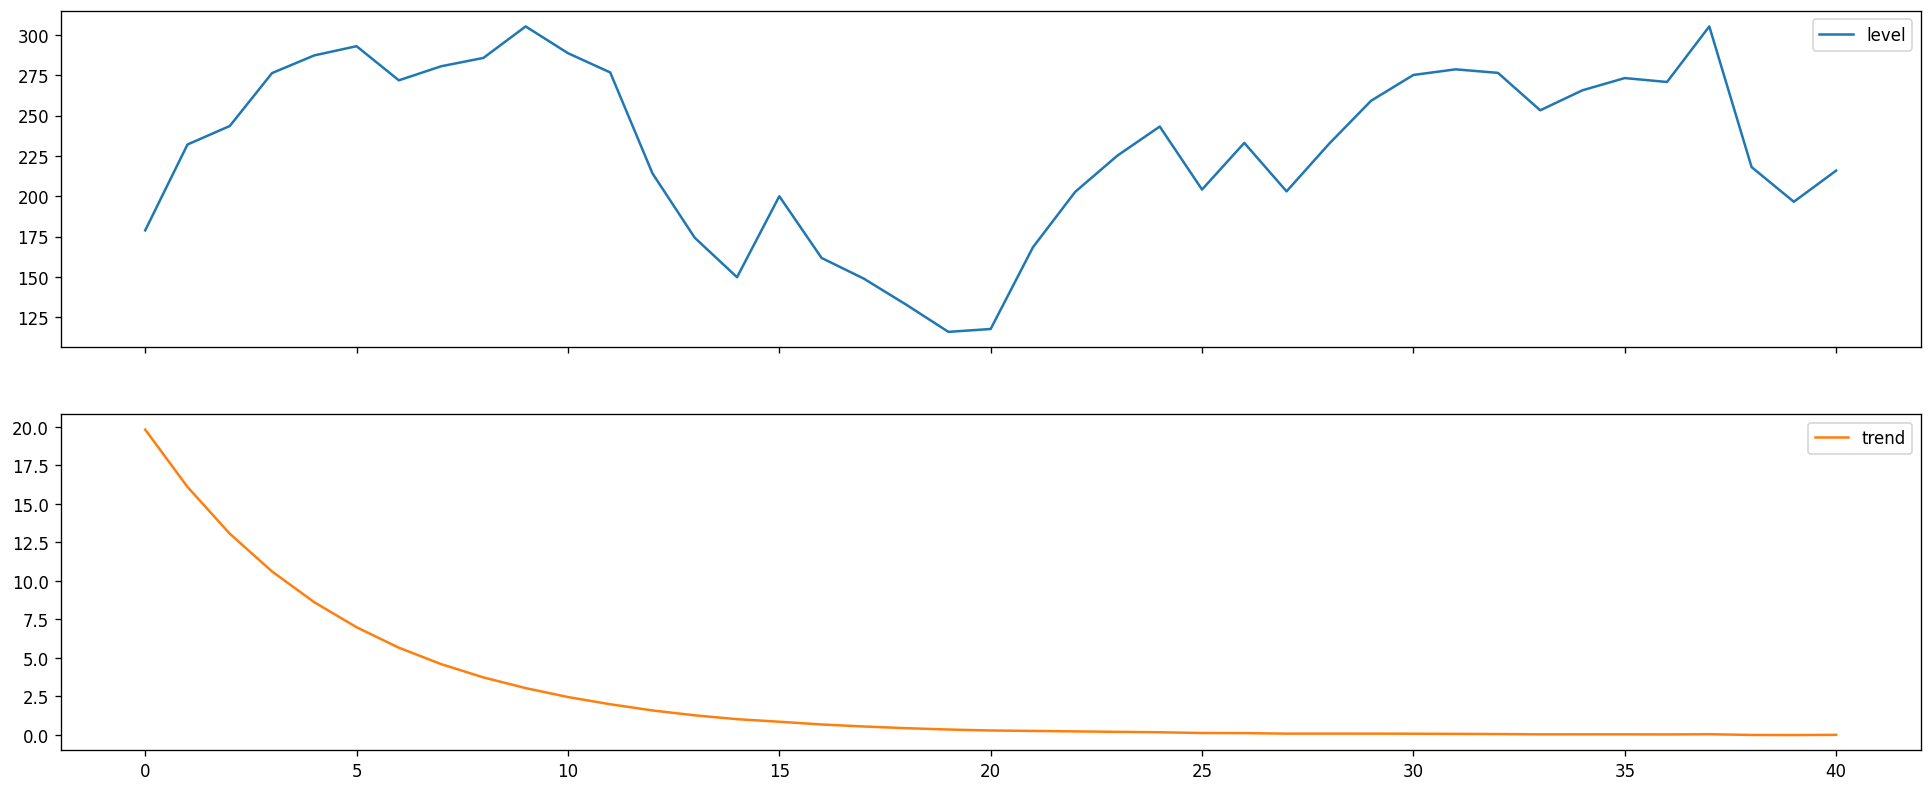

In [198]:
pd.DataFrame(np.c_[SEH_base.level, SEH_base.trend]).rename(
    columns={0: "level", 1: "trend"}
).plot(subplots=True)

plt.show()


#### como calcular o erro do metodo de holt?

O metodo de holts tem 2 hyperparametros serem ajustados, mas tambem uma serie de metodos de calculo que variam os resultados
 - exponential=True
 - damped_trend=True
 - entre outros 

In [200]:
print('erro (RMSE) da modelagem \t',
         mean_squared_error(df_results_SEH['y_true'][:41],
                            df_results_SEH['y_pred'][:41],
                            squared=False))

print('erro (RMSE) da previsao \t',
         mean_squared_error(df_results_SEH['y_true'][41:],
                            df_results_SEH['y_pred'][41:],
                            squared=False))

erro (RMSE) da modelagem 	 75.12564422984332
erro (RMSE) da previsao 	 79.71815394184111


## Metodo de Holt Winters

### escolha dos parametros

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


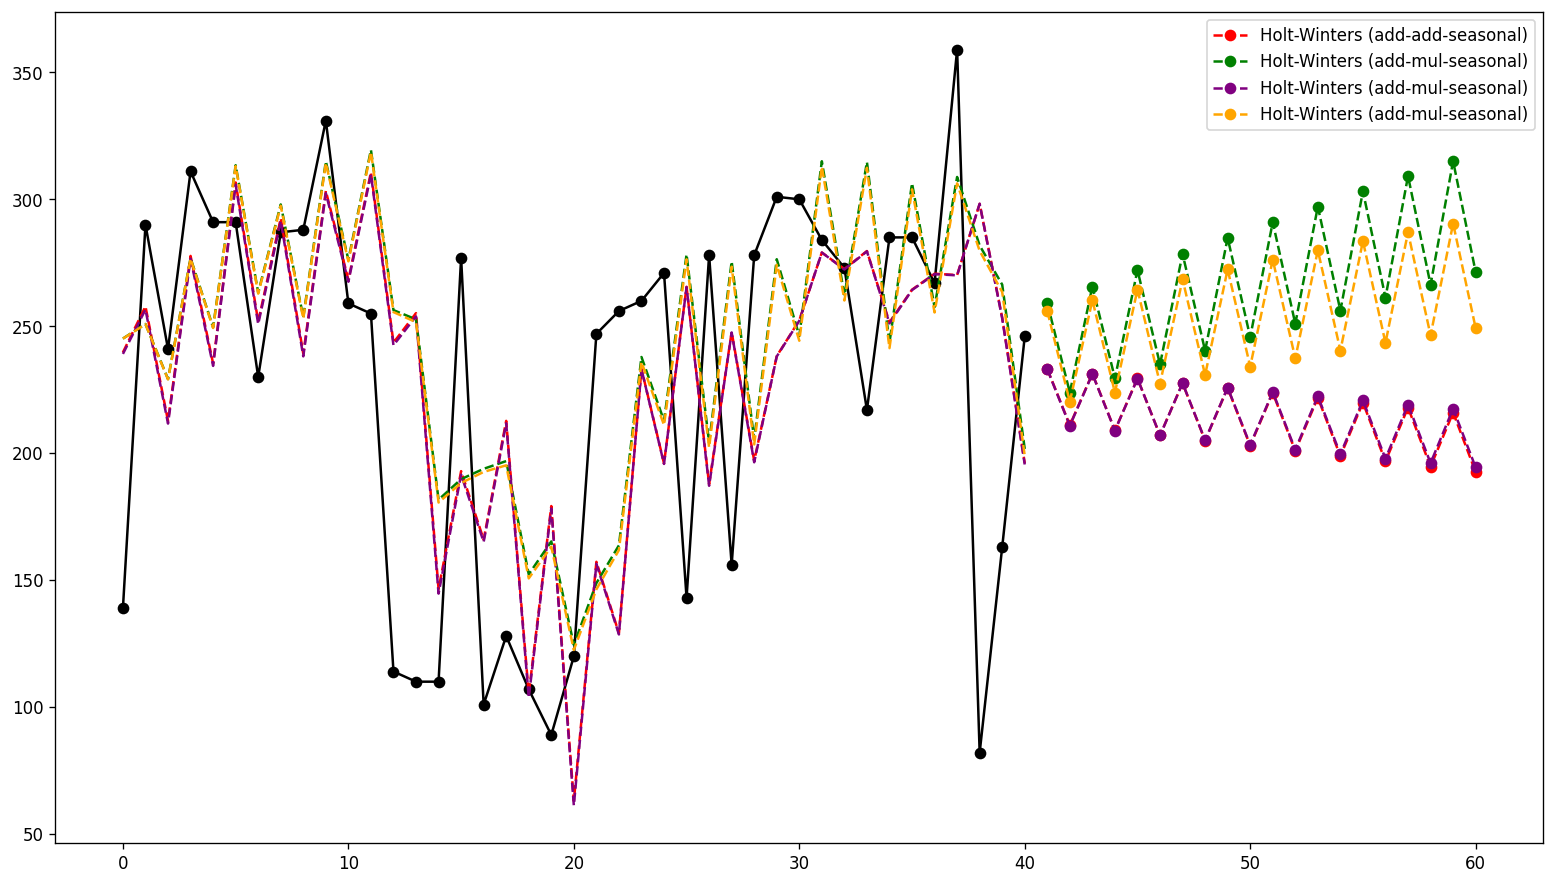

melhor desempenho fica com multiplicative WH damped, mas por muito pouco


Additive  Multiplicative  Additive Dam  Multiplica Dam
$\alpha$     0.322612        0.358571      0.325207        0.358571
$\beta$      0.000700        0.000100      0.000100        0.000100
$\phi$            NaN             NaN      0.989440        0.990000
$\gamma$     0.088190        0.000100      0.087757        0.000100
$l_0$     5746.920811     5754.481867   5742.590067     5754.481867
$b_0$      -30.838784      104.571160    -48.119789      104.571160
RMSE        76.192592       75.694386     76.175591       75.415384

In [202]:
WH1 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="add",use_boxcox=True,initialization_method="estimated").fit()
WH2 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="mul",use_boxcox=True,initialization_method="estimated").fit()
WH3 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="add",damped_trend=True,use_boxcox=True,initialization_method="estimated").fit()
WH4 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="mul",damped_trend=True,use_boxcox=True,initialization_method="estimated").fit()

erros_WH = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "RMSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
erros_WH["Additive"] = [WH1.params[p] for p in params] +        [mean_squared_error(X_train['Volume'],WH1.fittedvalues, squared=False)]
erros_WH["Multiplicative"] = [WH2.params[p] for p in params] +  [mean_squared_error(X_train['Volume'],WH2.fittedvalues, squared=False)]
erros_WH["Additive Dam"] = [WH3.params[p] for p in params] +    [mean_squared_error(X_train['Volume'],WH3.fittedvalues, squared=False)]
erros_WH["Multiplica Dam"] = [WH4.params[p] for p in params] +  [mean_squared_error(X_train['Volume'],WH4.fittedvalues, squared=False)]

ax = X_train['Volume'].plot(figsize=(16, 9),marker="o",color="black")

WH1.fittedvalues.plot(ax=ax, style="--", color = 'red')
WH2.fittedvalues.plot(ax=ax, style="--", color = 'green')
WH3.fittedvalues.plot(ax=ax, style="--", color = 'purple')
WH4.fittedvalues.plot(ax=ax, style="--", color = 'orange')

WH1.forecast(20).rename("Holt-Winters (add-add-seasonal)").plot(ax=ax, style="--", marker="o", color="red", legend=True)
WH2.forecast(20).rename("Holt-Winters (add-mul-seasonal)").plot(ax=ax, style="--", marker="o", color="green", legend=True)
WH3.forecast(20).rename("Holt-Winters (add-mul-seasonal)").plot(ax=ax, style="--", marker="o", color="purple", legend=True)
WH4.forecast(20).rename("Holt-Winters (add-mul-seasonal)").plot(ax=ax, style="--", marker="o", color="orange", legend=True)

plt.show()
print('melhor desempenho fica com multiplicative WH damped, mas por muito pouco')

erros_WH

### modelagem

41    255.974064
42    220.289746
43    260.272172
44    223.901717
45    264.440993
46    227.405882
47    268.486324
48    230.807006
49    272.413546
50    234.109520
51    276.227672
52    237.317552
53    279.933377
54    240.434964
55    283.535039
56    243.465368
57    287.036760
58    246.412158
59    290.442392
60    249.278523
61    293.755564
62    252.067468
63    296.979695
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


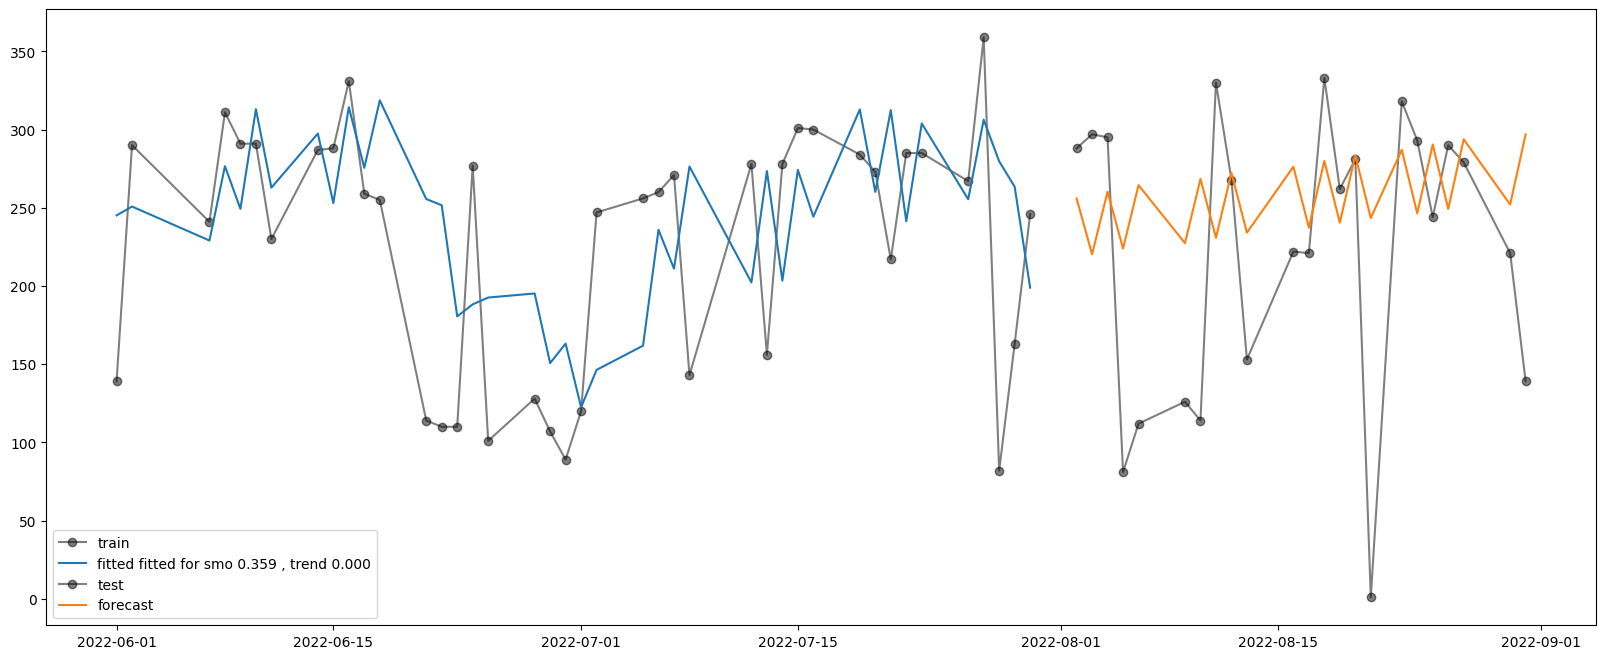

In [23]:
plt.figure(figsize=(20, 8))

WH4 = ExponentialSmoothing(X_train['Volume'],seasonal_periods=2,trend="add",seasonal="mul",damped_trend=True,use_boxcox=True,initialization_method="estimated").fit()

plt.plot(X_train['Data'],X_train['Volume'].values, marker="o", color="black", alpha = 0.5)
plt.plot(X_train['Data'],WH4.fittedvalues)
plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)
plt.plot(X_test['Data'],WH4.forecast(23))
print(WH4.forecast(23))

plt.legend(loc = 'lower left', labels = ['train',
                    'fitted {}'.format('fitted for smo {:.3f} , trend {:.3f}'.format(WH4.model.params["smoothing_level"], WH4.model.params["smoothing_trend"])),
                    'test', 'forecast'])

plt.show();


In [212]:
results = list()
df_results_WH = pd.DataFrame()

for i in range(X_train.shape[0], volumes_totais_diarios.shape[0]+1):
    
    X = volumes_totais_diarios.iloc[:i]

    ### primeiro adiciona aos resultados os valores de treinamento
    ### Esse passo tambem determina o parameto de suavizacao para o step by step
    if i == X_train.shape[0]:
        WH_base = ExponentialSmoothing( X['Volume'],
                                        seasonal_periods=2,
                                        trend="add",
                                        seasonal="mul",
                                        damped_trend=True,
                                        use_boxcox=True,
                                        initialization_method="estimated").fit(optimized = True)
        [results.append(WH_base.fittedvalues[i]) for i in range(len(WH_base.fittedvalues))]
    
    ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
    else:
        WH_step = ExponentialSmoothing( X['Volume'],
                                        seasonal_periods=2,
                                        trend="add",
                                        seasonal="mul",
                                        damped_trend=True,
                                        use_boxcox=True,
                                        initialization_method="estimated").fit( smoothing_level = WH_base.model.params["smoothing_level"],
                                                                                smoothing_trend = WH_base.model.params["smoothing_trend"],
                                                                                optimized = True  )
        results.append(WH_step.fittedvalues[i-1])


df_results_WH = pd.concat([X,pd.Series(results)], axis = 1, ignore_index = True)
df_results_WH.columns = ['Data', 'y_true', 'y_pred']
print('smoothing_level =',WH_base.model.params["smoothing_level"])
print('smoothing_trend =',WH_base.model.params["smoothing_trend"])
df_results_SEH


smoothing_level = 0.3585714285714286
smoothing_trend = 0.0001


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization f

Data  y_true      y_pred
0  2022-06-01     139  204.342813
1  2022-06-02     290  194.891503
2  2022-06-07     241  245.109988
3  2022-06-08     311  254.098244
4  2022-06-09     291  284.933698
..        ...     ...         ...
58 2022-08-25     244  291.748919
59 2022-08-26     290  273.971567
60 2022-08-27     279  280.956831
61 2022-08-30     221  280.181379
62 2022-08-31     139  256.051682

[63 rows x 3 columns]

In [219]:
df_results_WH[38:45]

Data  y_true      y_pred
38 2022-07-28      82  279.695134
39 2022-07-29     163  263.478878
40 2022-07-30     246  198.938469
41 2022-08-02     288  255.929700
42 2022-08-03     297  232.443258
43 2022-08-04     295  301.567929
44 2022-08-05      81  258.578587

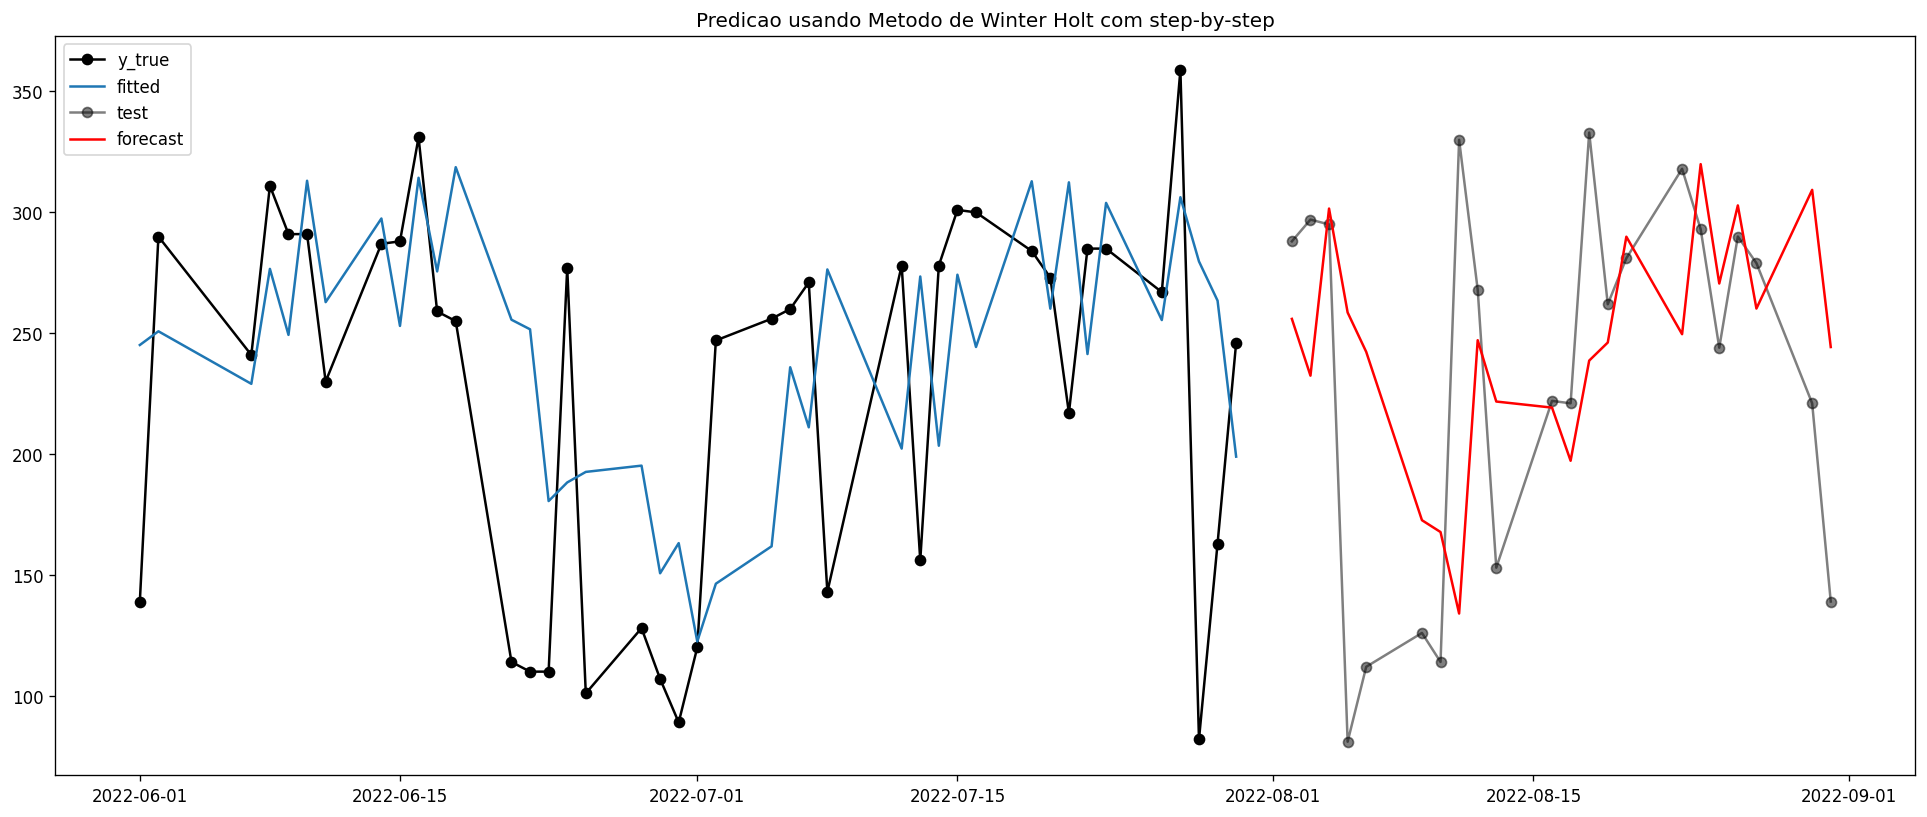

In [281]:
plt.figure(figsize=(20, 8))

######## y_pred[:41] deve ser igual ao fit1.fittedvalues E O FATO SE CONFIRMA COM O CODIGO ABAIXO

# fit1 = SimpleExpSmoothing(X_train['Volume'].values, initialization_method="heuristic").fit()
# plt.plot(X_train['Data'],fit1.fittedvalues, color = 'pink')


plt.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")

plt.plot(X_train['Data'],df_results_WH['y_pred'][:41])

plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)

plt.plot(X_test['Data'],df_results_WH['y_pred'][41:], color='red')

plt.legend(loc = 'upper left', labels = ['y_true', 'fitted', 'test', 'forecast'])

plt.title('Predicao usando Metodo de Winter Holt com step-by-step')


plt.show();

In [216]:
print('erro (RMSE) da modelagem \t',
         mean_squared_error(df_results_WH['y_true'][:41],
                            df_results_WH['y_pred'][:41],
                            squared=False))

print('erro (RMSE) da previsao \t',
         mean_squared_error(df_results_WH['y_true'][41:],
                            df_results_WH['y_pred'][41:],
                            squared=False))

erro (RMSE) da modelagem 	 75.4153840928871
erro (RMSE) da previsao 	 79.11201113902855


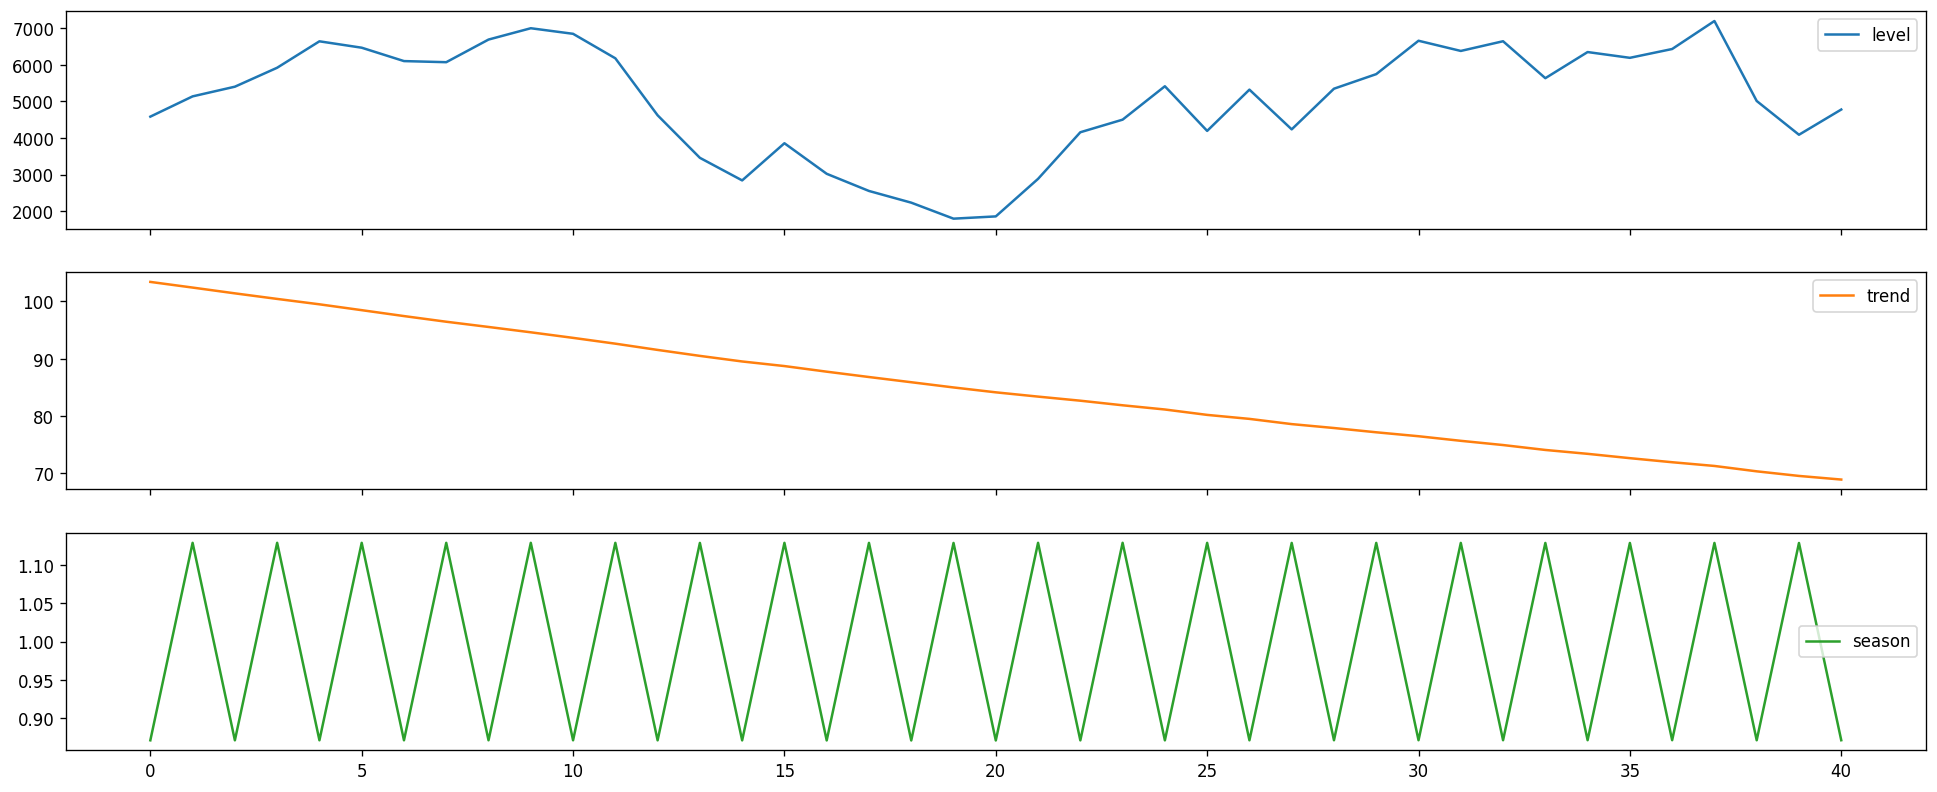

In [218]:
pd.DataFrame(np.c_[WH_base.level, WH_base.trend, WH_base.season]).rename(
    columns={0: "level", 1: "trend", 2:"season"}
).plot(subplots=True)
plt.show()


## ARIMA

### Determinação dos parâmetros do ARIMA

#### Checar se a série é estacionária
A série estacionária é condição _sine qua non_ para a aplicação do método; caso nao for, é possível utilizar a diferenciação da série - quantas vezes forem necessárias -  para torná-la estacionária. Escolhido o radar, observa-se se a série pode ser considerada estacionária (p-value inferior a 0.05) por meio do teste de Dickey-Fuller aumentado (ADF).

In [220]:
result_adfuller = adfuller(X_train.Volume)
print('ADF Statistic: %f' % result_adfuller[0])
print('p-value: %f' % result_adfuller[1])

ADF Statistic: -4.331597
p-value: 0.000391


#### Validação Visual

Para validar visualmente o resultado do teste ADF, plotamos funções de autocorrelação para a série original, com diferenciação de primeira e de segunda ordem. 

Espera-se que a série original tenha uma curva da Função de Autocorrelação (ACF) decrescente enquanto as outras possuam uma queda abrupta pois, segundo o teste ADF, elas já serão diferenciadas.

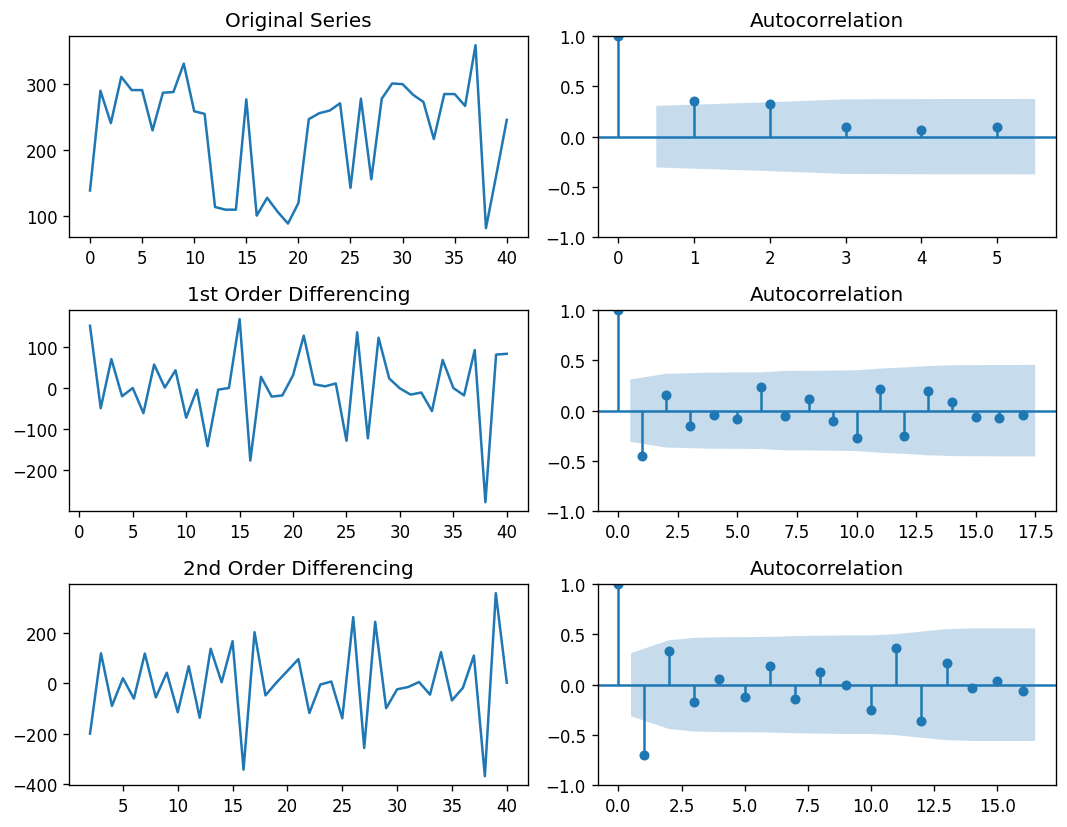

In [29]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
fig, axes = plt.subplots(3, 2, sharex=False)

# Original Series
axes[0, 0].plot(X_train.Volume); axes[0, 0].set_title('Original Series')
plot_acf(X_train.Volume, ax=axes[0, 1], alpha=0.05, lags=5)

# 1st Differencing
axes[1, 0].plot(X_train.Volume.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(X_train.Volume.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(X_train.Volume.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(X_train.Volume.diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout()
plt.show()

Os plots mostram que na primeira diferenciação, a série já se torna super diferenciada (o que pode ser notado pela queda abrupta na curva de autocorrelação). Isso indica que o parâmetro d=0 é realmente o ideal

#### Ordem da Auto-Regressão

Por se tratar de uma regressão feita sobre os valores anteriores da série, deve-se ver até que ponto há correlação entre os pontos de observação. Isso é definido através da Função de Autocorrelação Parcial (PACF).

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


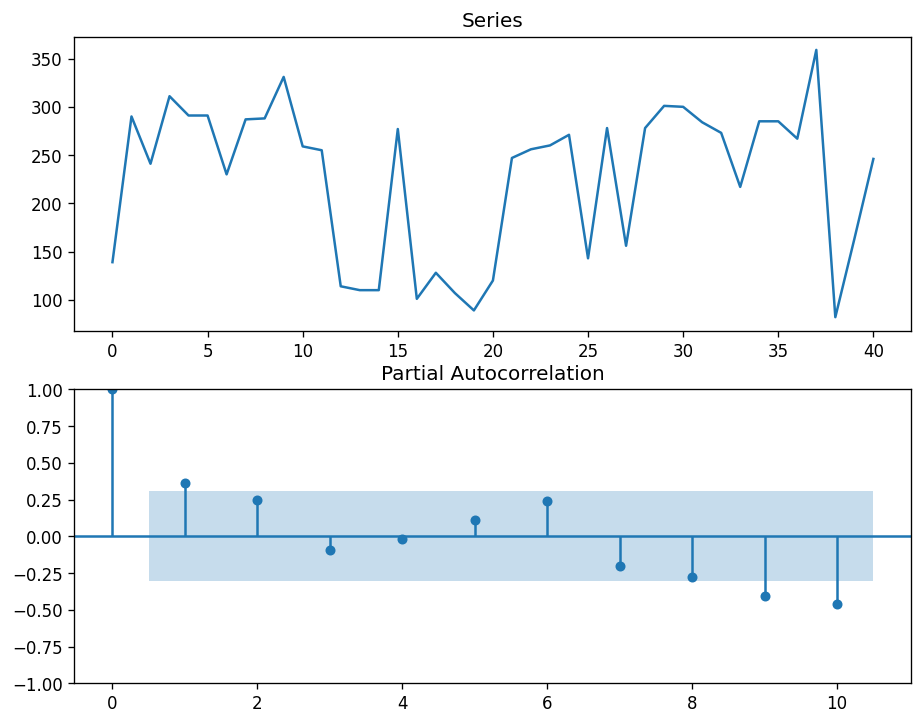

In [222]:
# PACF
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(2, 1, sharex=False)
axes[0].plot(X_train.Volume); axes[0].set_title('Series')
axes[1].set(ylim=(0,1.5))
plot_pacf(X_train.Volume, ax=axes[1], lags= 10)

plt.show()

#### Ordem da Média-Móvel

O plot da ACF fornece um threshold, um limite, superior para o ordem do modelo MA. 

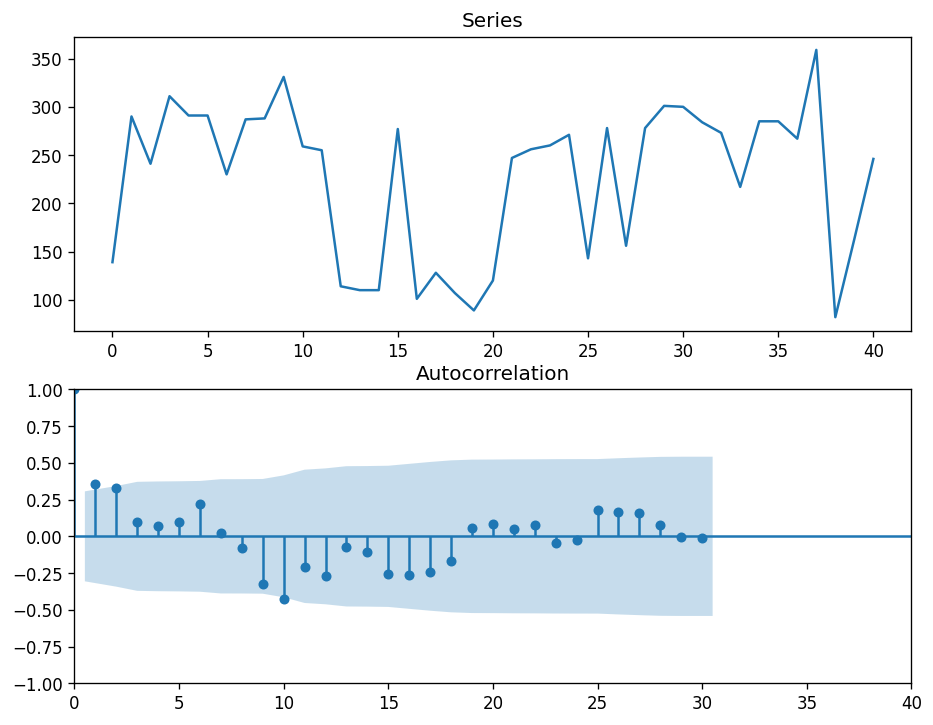

In [223]:
fig, axes = plt.subplots(2,1, sharex=False)


axes[0].plot(X_train.Volume); axes[0].set_title('Series')
axes[1].set(ylim=(0,1.2), xlim=(0,40))
plot_acf(X_train.Volume, ax=axes[1], lags=30)


# plt.annotate('Entra na área de significância', xytext=(30, 1),xy=(43,0.4),arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

A autocorrelação decai muito lentamente para a série em questão. 


Isso nos daria um treshold máximo da ordem de 40. No entanto, vale ressaltar que esse valor pode ser muito elevado, então deve-se sempre levar em conta tanto o fator de **performance do modelo** quanto **custo computacional**, evitando o uso de parâmetros muito elevados em quaisquer modelos.

Nos modelos ARIMA, a componente de média móvel raramente ultrapassa 3 ou 4. Por isso, utilizaremos o valor 1 para manter o modelo simples.

#### Modelagem

In [267]:
p = 1 #Autoregressao
d = 1 #Diferenciacao
q = 2 #MediaMovel
# steps = 5 # Steps a serem previstos

# Instancia o modelo e faz o fit no treino
model = ARIMA(X_train['Volume'],order=(p,d,q)).fit()

# Realiza FORECAST
fc = model.predict(19, alpha=0.05)  # 95% conf


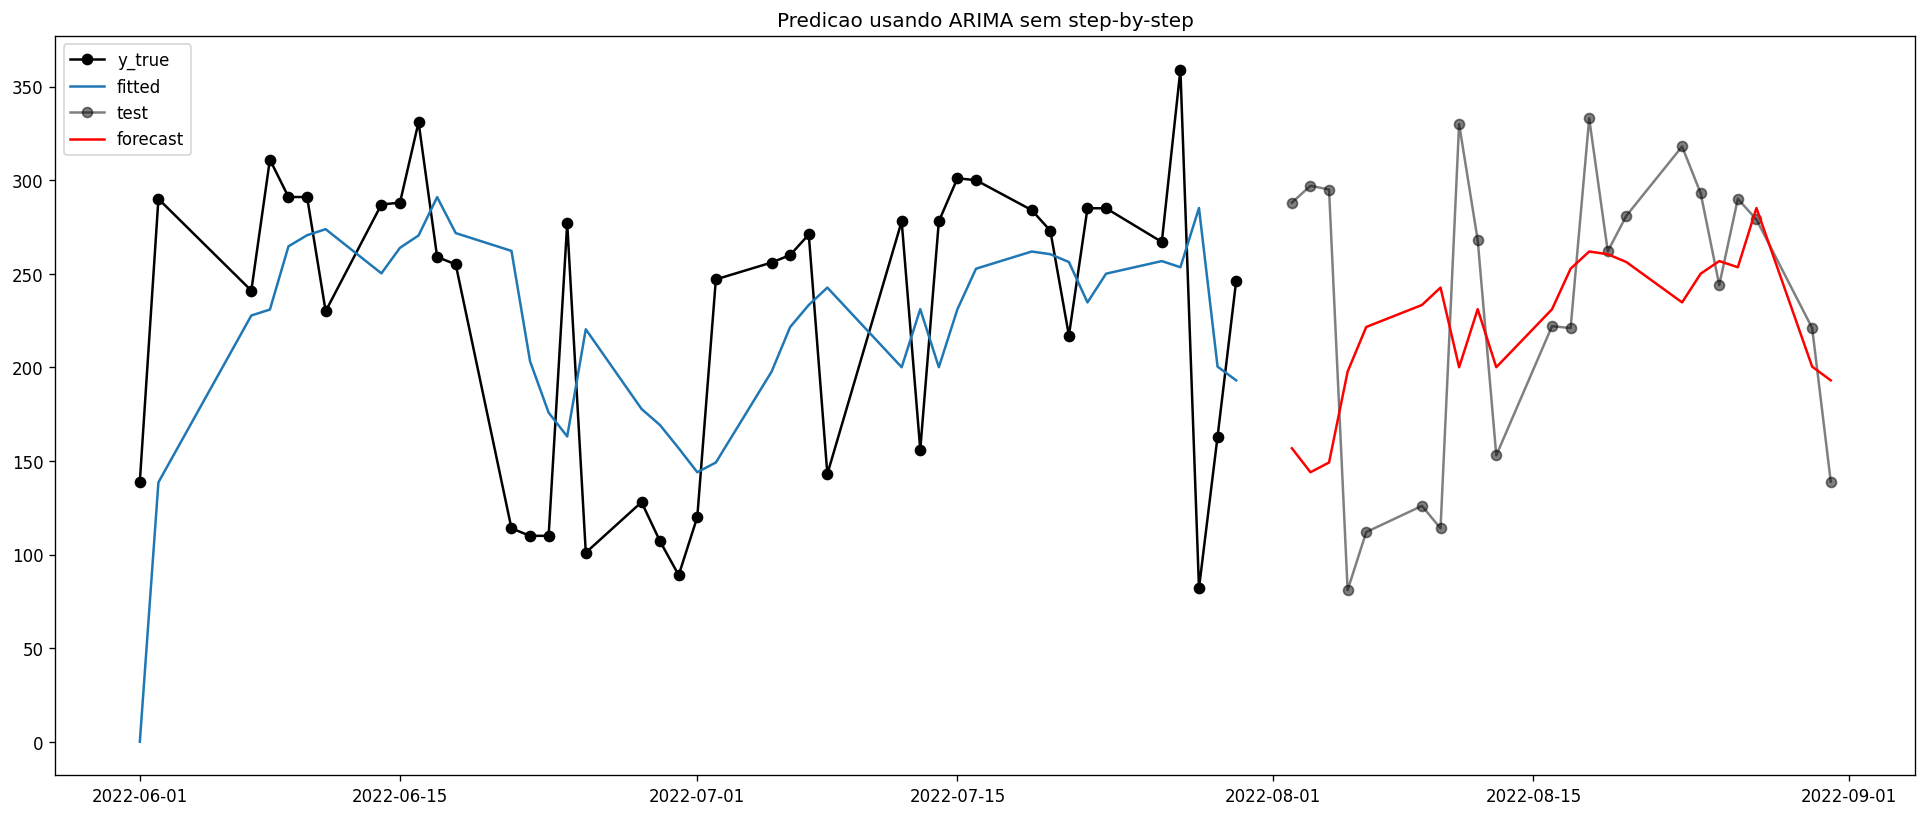

In [282]:
# Plot
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")

ax.plot(X_train['Data'],model.fittedvalues)

ax.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)

ax.plot(X_test['Data'],fc, color='red')

plt.legend(loc = 'upper left', labels = ['y_true', 'fitted','test', 'forecast'])

plt.title('Predicao usando ARIMA sem step-by-step')

plt.show()

In [272]:
results = list()
df_results_ARIMA = pd.DataFrame()

p = 1 #Autoregressao
d = 1 #Diferenciacao
q = 2 #MediaMovel

for i in range(X_train.shape[0], volumes_totais_diarios.shape[0]+1):
    
    X = volumes_totais_diarios.iloc[:i]

    ### primeiro adiciona aos resultados os valores de treinamento
    ### Esse passo tambem determina o parameto de suavizacao para o step by step
    if i == X_train.shape[0]:
        ARIMA_base = ARIMA(X['Volume'],order=(p,d,q)).fit()
        
        [results.append(ARIMA_base.fittedvalues[i]) for i in range(len(ARIMA_base.fittedvalues))]
    
    ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
    else:
        ARIMA_step = ARIMA(X['Volume'],order=(p,d,q)).fit()
        results.append(ARIMA_step.fittedvalues[i-1])


df_results_ARIMA = pd.concat([X,pd.Series(results)], axis = 1, ignore_index = True)
df_results_ARIMA.columns = ['Data', 'y_true', 'y_pred']
df_results_SEH


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramet

Data  y_true      y_pred
0  2022-06-01     139  204.342813
1  2022-06-02     290  194.891503
2  2022-06-07     241  245.109988
3  2022-06-08     311  254.098244
4  2022-06-09     291  284.933698
..        ...     ...         ...
58 2022-08-25     244  291.748919
59 2022-08-26     290  273.971567
60 2022-08-27     279  280.956831
61 2022-08-30     221  280.181379
62 2022-08-31     139  256.051682

[63 rows x 3 columns]

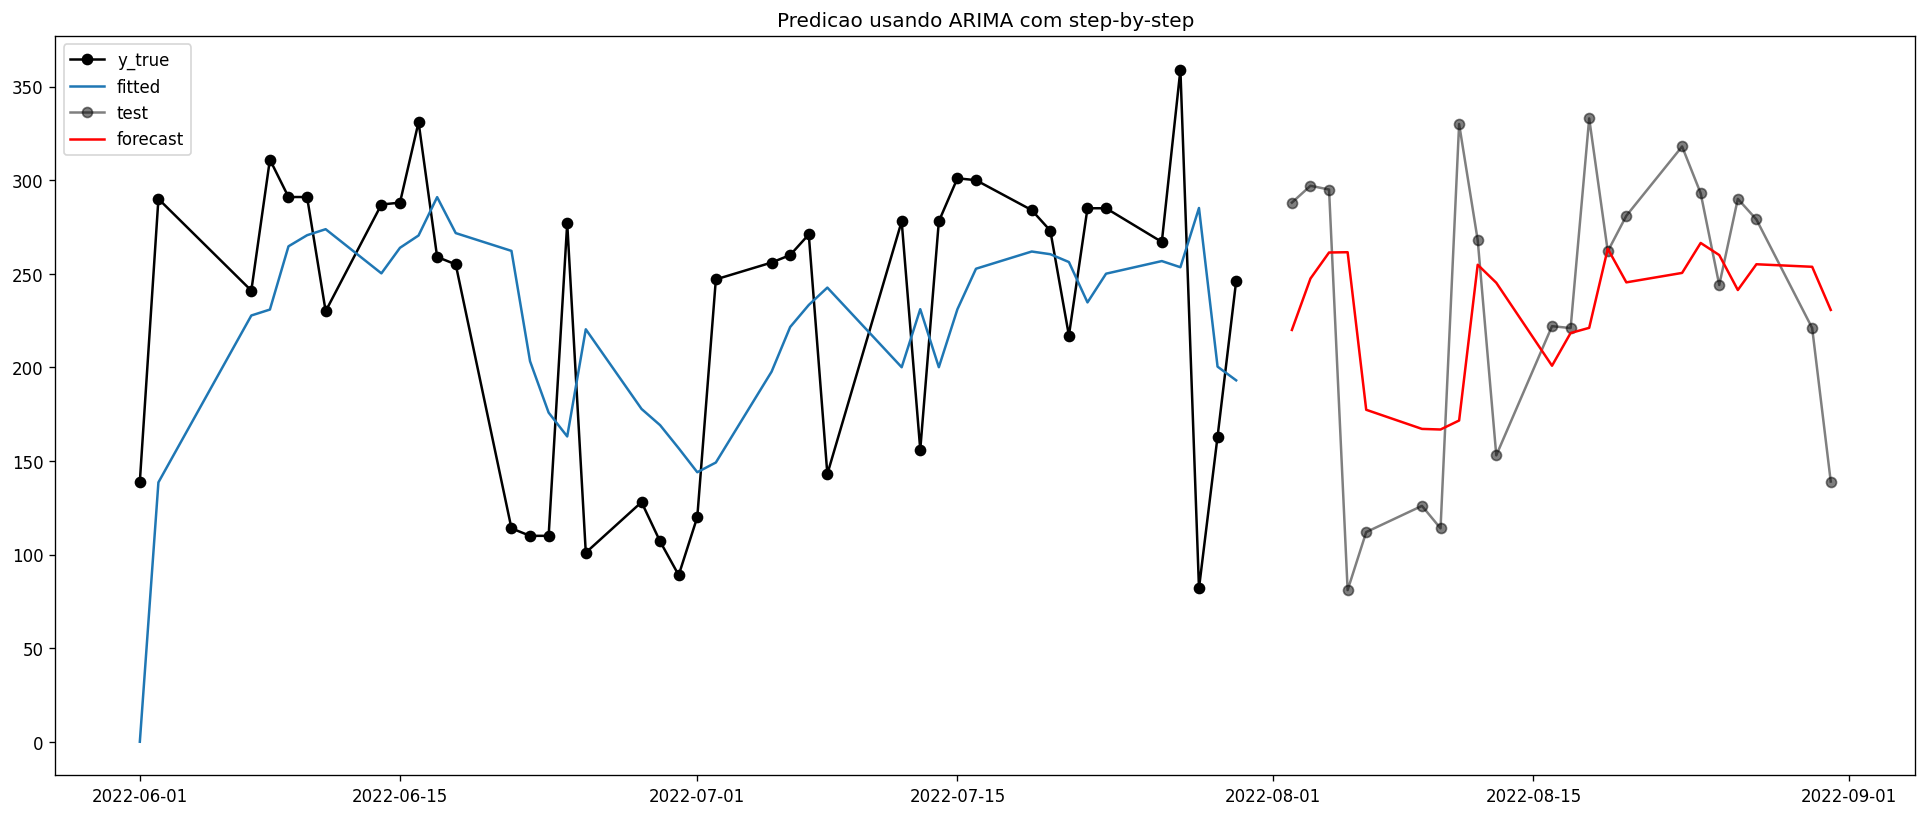

In [283]:
plt.figure(figsize=(20, 8))

plt.plot(X_train['Data'],X_train['Volume'], marker="o", color="black")

plt.plot(X_train['Data'],df_results_ARIMA['y_pred'][:41])

plt.plot(X_test['Data'],X_test['Volume'], marker="o", color="black", alpha = 0.5)

plt.plot(X_test['Data'],df_results_ARIMA['y_pred'][41:], color='red')

plt.legend(loc = 'upper left', labels = ['y_true', 'fitted', 'test', 'forecast'])

plt.title('Predicao usando ARIMA com step-by-step')


plt.show();

In [274]:
print('erro (RMSE) da modelagem \t',
         mean_squared_error(df_results_ARIMA['y_true'][:41],
                            df_results_ARIMA['y_pred'][:41],
                            squared=False))

print('erro (RMSE) da previsao \t',
         mean_squared_error(df_results_ARIMA['y_true'][41:],
                            df_results_ARIMA['y_pred'][41:],
                            squared=False))

erro (RMSE) da modelagem 	 77.43563729452751
erro (RMSE) da previsao 	 72.45417103424221


# Volume por dia da semana

## Organizacao dos volumes por dias da semana

0    3030
1    3067
2    3161
3    2740
4    2489
Name: dataInicio, dtype: int64


<AxesSubplot:>

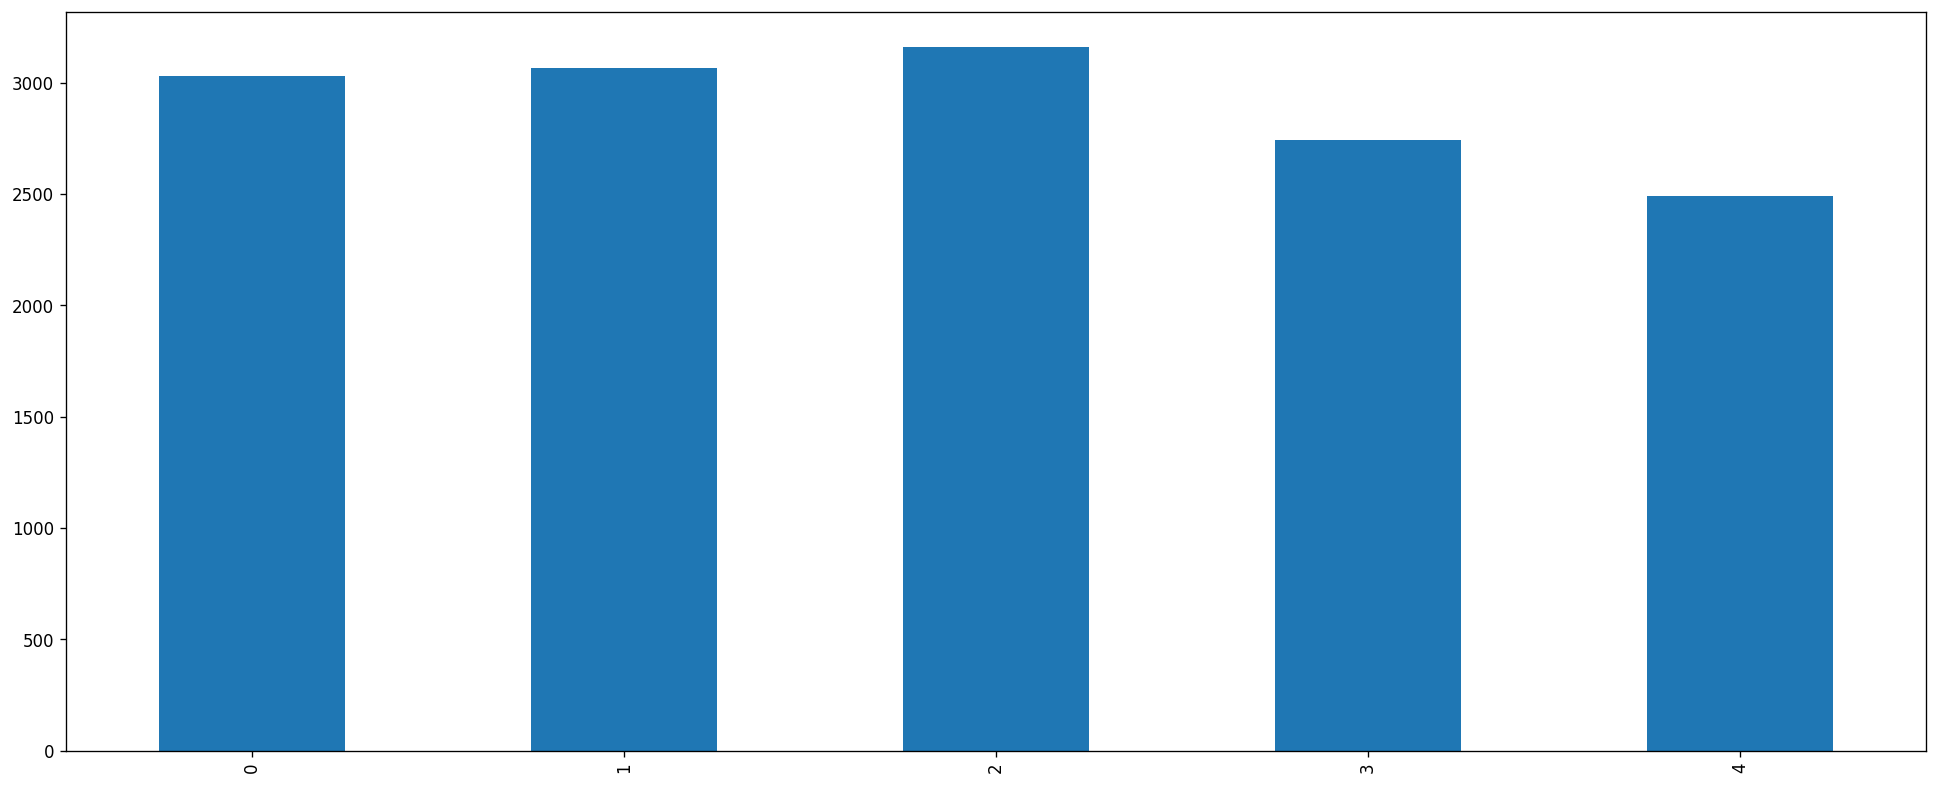

In [290]:
# 0 --> segunda
viagens_validas = viagens_validas.loc[viagens_validas.dataInicio.dt.day_of_week != 5]

print(viagens_validas.dataInicio.dt.day_of_week.value_counts().sort_index())
viagens_validas.dataInicio.dt.day_of_week.value_counts().sort_index().plot(kind = 'bar' )


In [291]:
vol_semanal = viagens_validas.groupby(['day_of_week', pd.Grouper(freq='1D',key = 'dataInicio')]).agg({'sequence':'count'}).reset_index()
vol_semanal.drop(index = vol_semanal.loc[vol_semanal['day_of_week'] == 5].index,inplace = True, axis = 0)
vol_semanal.columns = ['day_of_week',	'Data',	'Volume']

vol_semanal

day_of_week       Data  Volume
0             0 2021-06-07     241
1             0 2021-06-14     287
2             0 2021-06-21     114
3             0 2021-06-28     128
4             0 2021-07-05     256
..          ...        ...     ...
58            4 2021-07-30     246
59            4 2021-08-06     112
60            4 2021-08-13     153
61            4 2021-08-20     281
62            4 2021-08-27     279

[63 rows x 3 columns]

In [377]:
segundas =  vol_semanal.loc[vol_semanal['day_of_week'] == 0].reset_index(drop=True)
tercas =    vol_semanal.loc[vol_semanal['day_of_week'] == 1].reset_index(drop=True)
quartas =   vol_semanal.loc[vol_semanal['day_of_week'] == 2].reset_index(drop=True)
quintas =   vol_semanal.loc[vol_semanal['day_of_week'] == 3].reset_index(drop=True)
sextas =    vol_semanal.loc[vol_semanal['day_of_week'] == 4].reset_index(drop=True)

In [374]:
quintas

day_of_week       Data  Volume
0             3 2021-06-10     291
1             3 2021-06-17     259
2             3 2021-06-24     277
3             3 2021-07-01     120
4             3 2021-07-08     143
5             3 2021-07-15     301
6             3 2021-07-22     285
7             3 2021-07-29     163
8             3 2021-08-05      81
9             3 2021-08-12     268
10            3 2021-08-19     262
11            3 2021-08-26     290

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_24114/480119193.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ind].set_xticklabels(labels = segundas   .Data.dt.date , rotation = 60)


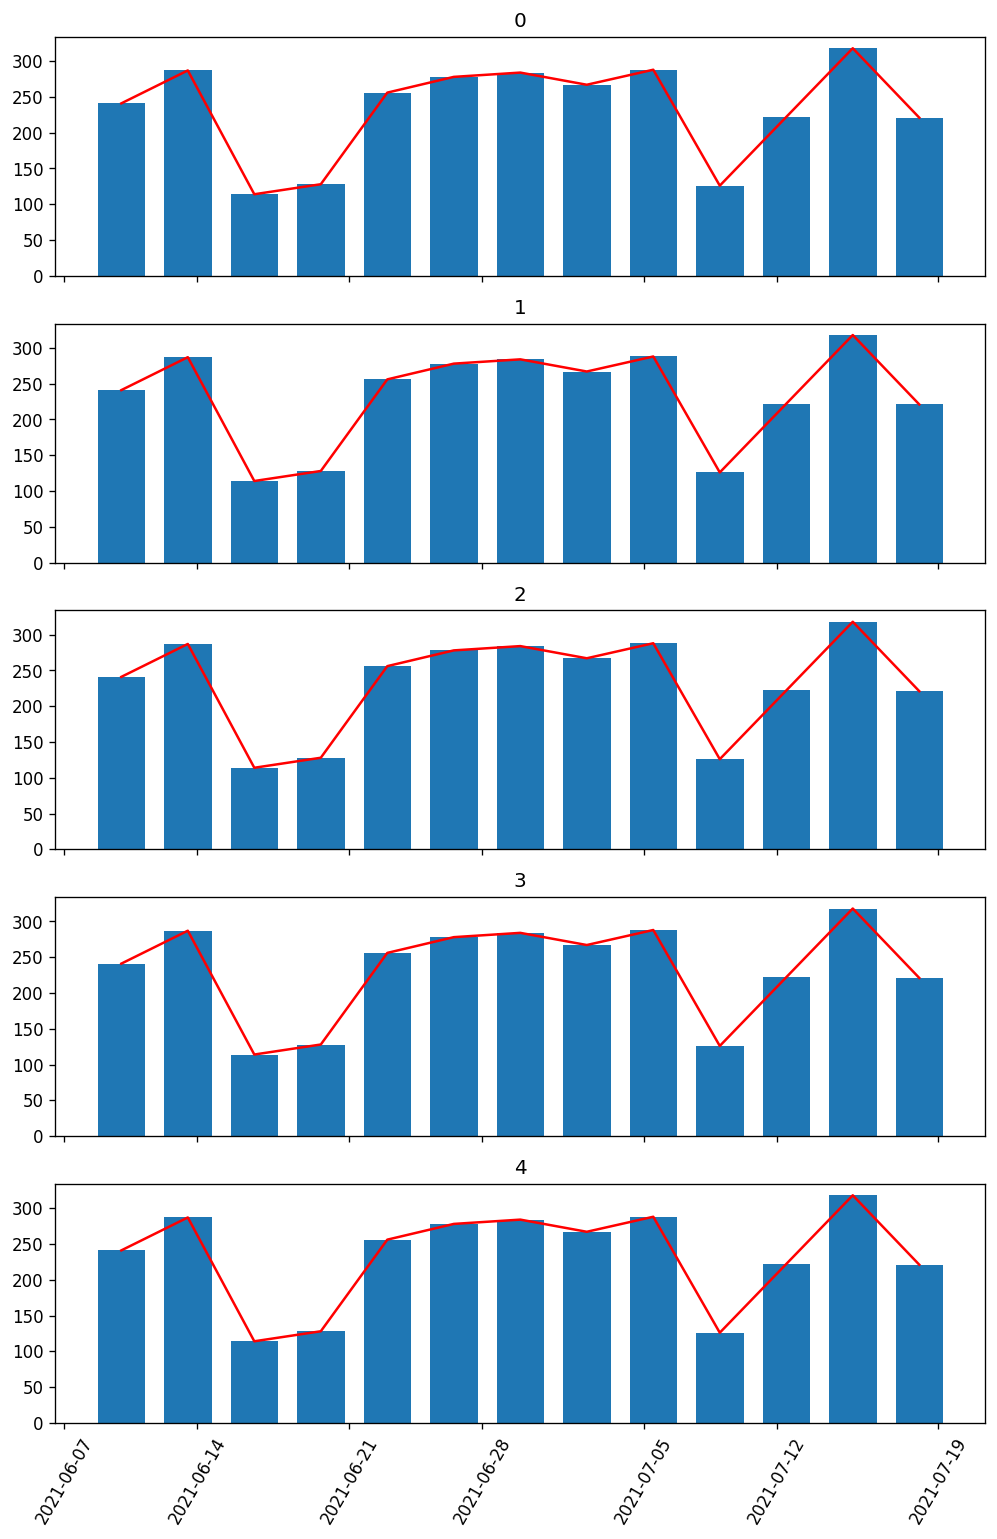

In [298]:
fig, ax = plt.subplots(5,figsize=(10,15), sharex= True, sharey = True)

for ind, weekday in enumerate([segundas, tercas, quartas, quintas, sextas]):
    ax[ind].bar(    segundas   .Data.dt.date, segundas   .Volume, width = 5)
    ax[ind].plot(   segundas   .Data.dt.date, segundas   .Volume, color = 'red')
    ax[ind].set_xticklabels(labels = segundas   .Data.dt.date , rotation = 60)    
    ax[ind].set_title(ind)



In [368]:
X_train_Seg,X_test_Seg  = segundas  [['Data', 'Volume']][:8].reset_index(drop=True), segundas[['Data', 'Volume']][8:].reset_index(drop=True)
X_train_Ter,X_test_Ter  = tercas    [['Data', 'Volume']][:8].reset_index(drop=True), tercas[['Data', 'Volume']][8:].reset_index(drop=True)
X_train_Qua,X_test_Qua  = quartas   [['Data', 'Volume']][:8].reset_index(drop=True), quartas[['Data', 'Volume']][8:].reset_index(drop=True)
X_train_Qui,X_test_Qui  = quintas   [['Data', 'Volume']][:8].reset_index(drop=True), quintas[['Data', 'Volume']][8:].reset_index(drop=True)
X_train_Sex,X_test_Sex  = sextas    [['Data', 'Volume']][:8].reset_index(drop=True), sextas[['Data', 'Volume']][8:].reset_index(drop=True)

X_train_Seg.shape, X_test_Seg.shape

((8, 2), (5, 2))

## Media Movel

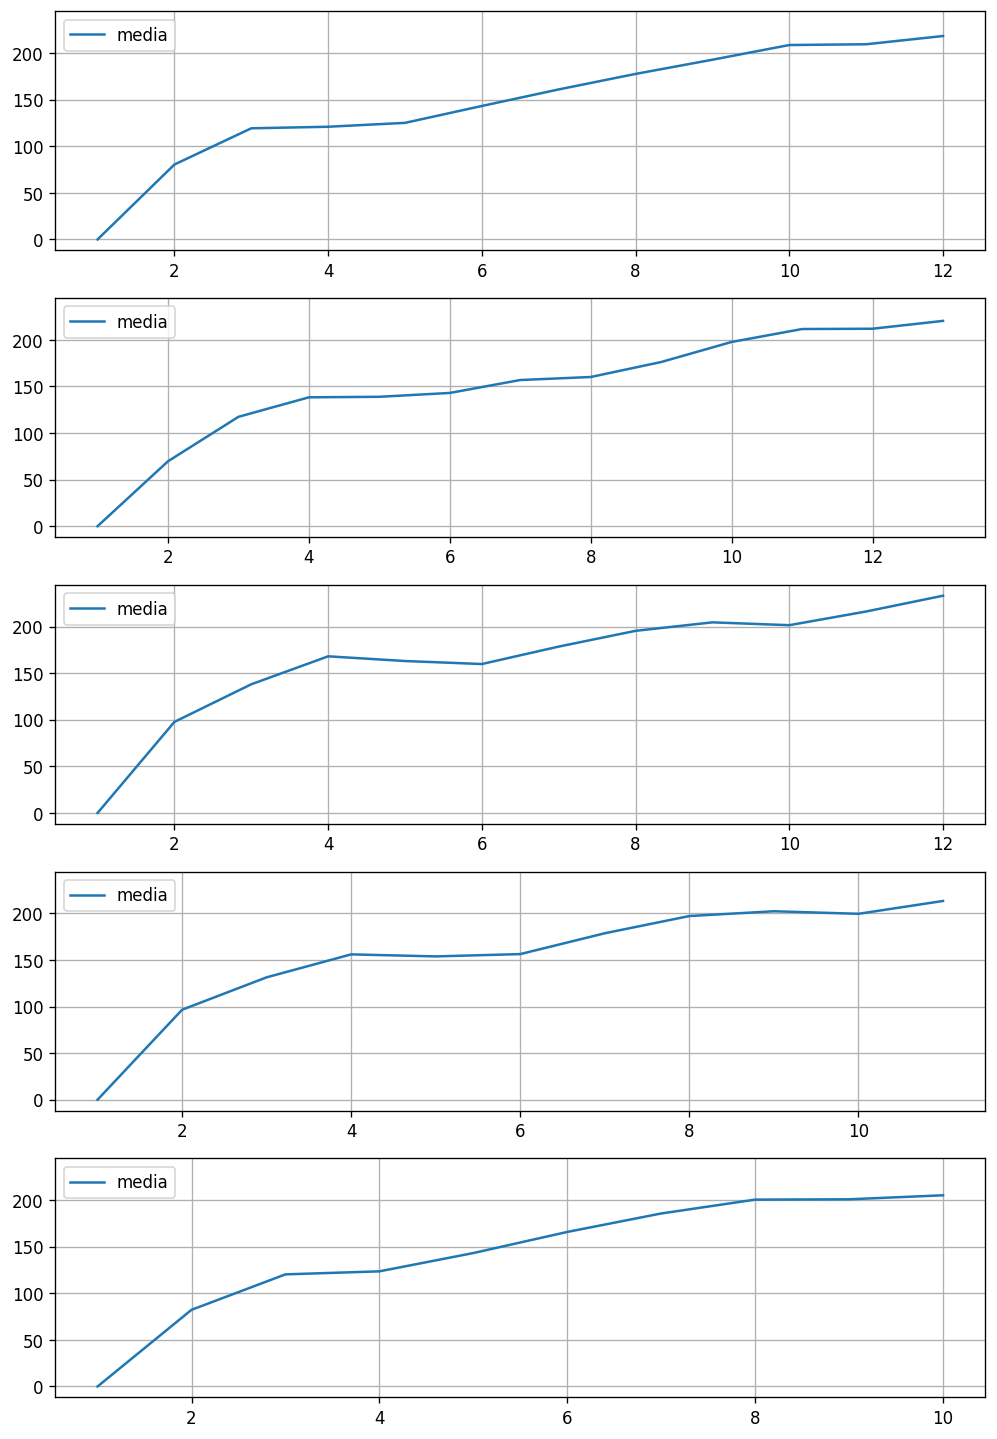

In [304]:
fig, ax = plt.subplots(nrows=5,figsize=(10,15), sharey = True)

for ind, weekday in enumerate([segundas, tercas, quartas, quintas, sextas]):

    erros_MA_diario = moving_average_test2(weekday)
    
    ax[ind].plot(erros_MA_diario.n_window, erros_MA_diario.RMSE)

    ax[ind].legend(loc= 'best',labels = ['media', 'mediana'])

    ax[ind].grid(visible=True, which = 'both')

plt.show()

/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_24114/2252867034.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['media_movel4'] = df['Volume'].rolling(4).mean()
/var/folders/21/6bbwtzhx0js126xjwqnzpzzc0000gn/T/ipykernel_24114/2252867034.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx].set_xticklabels(labels = df   .Data.dt.date , rotation = 60)


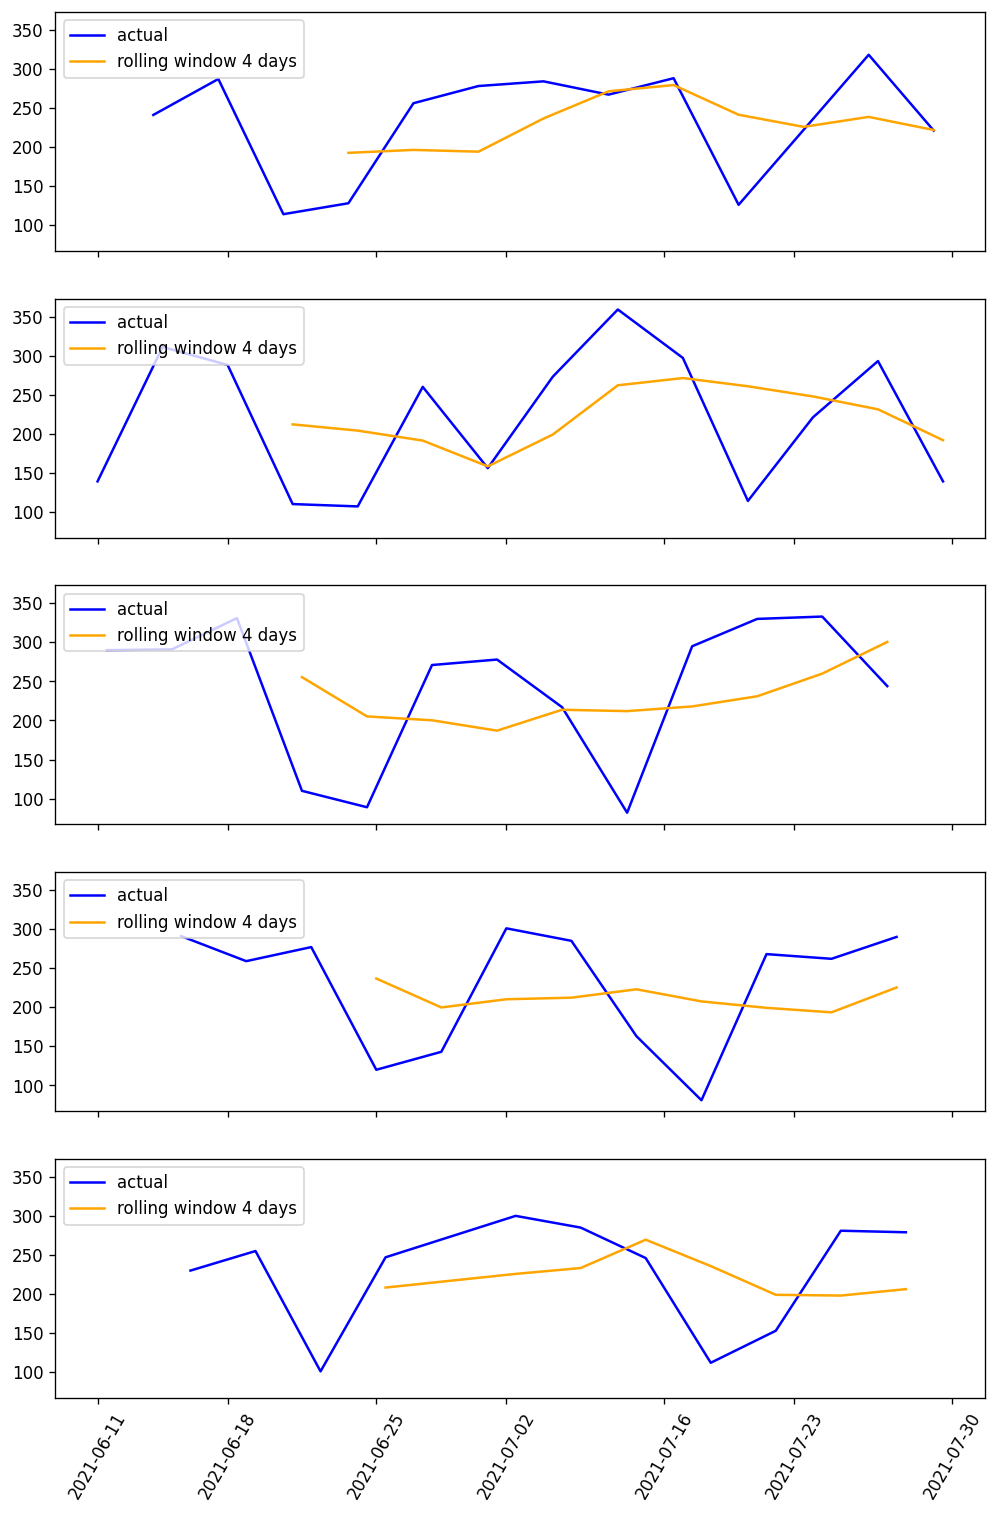

In [338]:
fig, ax = plt.subplots(nrows=5,figsize=(10,15), sharex= True, sharey = True)

for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

    df['media_movel4'] = df['Volume'].rolling(4).mean()
    ax[idx].plot(df   .Data.dt.date, df   .Volume, color = 'blue')
    ax[idx].plot(df   .Data.dt.date, df   .media_movel4, color = 'orange')
    ax[idx].legend(loc = 'upper left', labels = ['actual', 'rolling window 4 days'])
    ax[idx].set_xticklabels(labels = df   .Data.dt.date , rotation = 60)

    # ax[idx].set_title('')

plt.show()

#### Media Movel com step-by-step

In [411]:
segundas_MA =  segundas .copy()
tercas_MA =    tercas   .copy()
quartas_MA =   quartas  .copy()
quintas_MA =   quintas  .copy()
sextas_MA =    sextas   .copy()

dfs_MA = [segundas_MA, tercas_MA, quartas_MA, quintas_MA, sextas_MA]


for idx, df in enumerate(dfs_MA):
    results = list()

    for i in range(8, df.shape[0]+1):
        
        X = df.iloc[:i]

        ### primeiro adiciona aos resultados os valores de treinamento
        ### Esse passo tambem determina o parameto de suavizacao para o step by step
        if i == 8:
            MA_base = X['Volume'].rolling(4).mean().fillna(0)
            [results.append(MA_base.values[i]) for i in range(len(MA_base))]
        
        ### depois executa step by step e adiciona a ultima previsao de cada passo aos resultados
        else:
            MA_base = X['Volume'].rolling(4).mean()
            results.append(MA_base.values[-1])

    df = pd.concat([df,pd.Series(results, name = 'MA4')], axis = 1, ignore_index = True)
    df.columns = ['DOW', 'Data', 'y_true', 'y_pred']
    dfs_MA[idx] = df.copy()


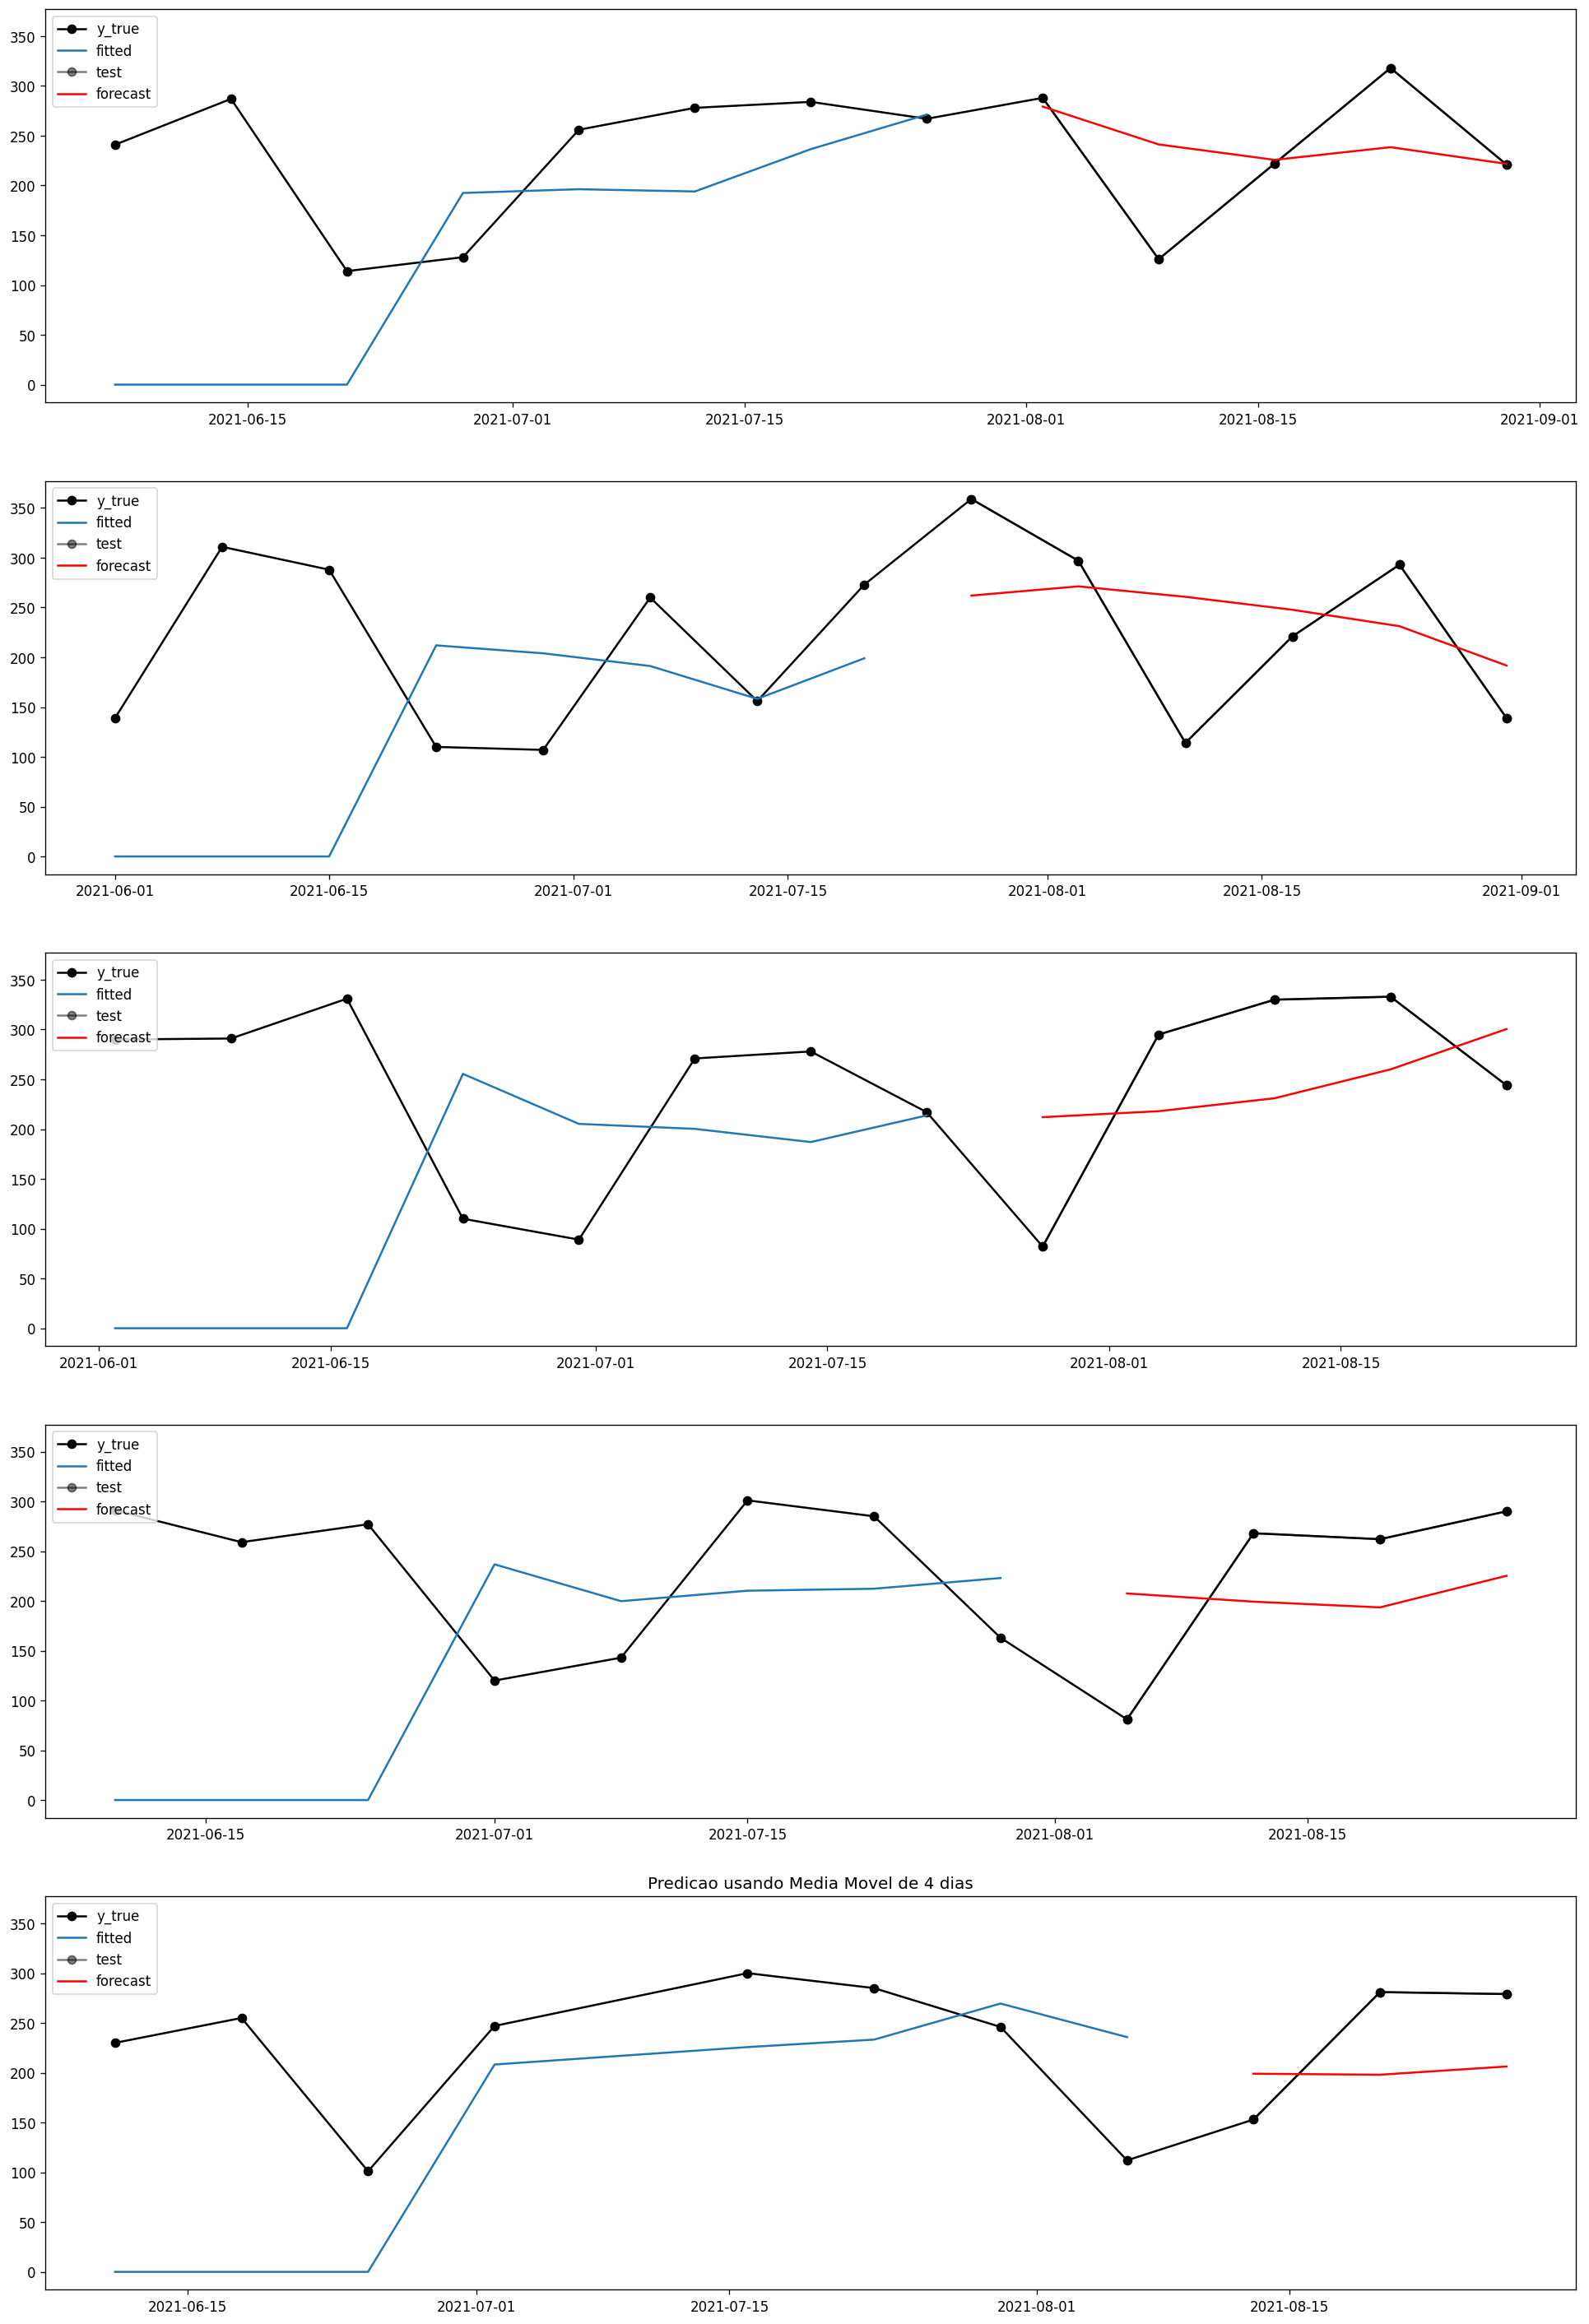

In [415]:
# plt.rcParams["figure.figsize"] = (10,15)

fig, ax = plt.subplots(nrows=5,figsize=(20,30), sharey = True)

for idx, df in enumerate(dfs_MA):

    # actual values
    ax[idx].plot(dfs_MA[idx]['Data'],dfs_MA[idx]['y_true'], marker="o", color="black")

    # result of trained values
    ax[idx].plot(dfs_MA[idx]['Data'][:8],dfs_MA[idx]['y_pred'][:8])

    # actual future values
    ax[idx].plot(dfs_MA[idx]['Data'][8:],dfs_MA[idx]['y_true'][8:], marker="o", color="black", alpha = 0.5)

    # predicted values
    ax[idx].plot(dfs_MA[idx]['Data'][8:],dfs_MA[idx]['y_pred'][8:], color='red')

    ax[idx].legend(loc = 'upper left', labels = ['y_true', 'fitted', 'test', 'forecast'])
plt.title('Predicao usando Media Movel de 4 dias')

plt.show()

### calculo do erro

In [420]:
print('DF1 = Segundas')
print('DF2 = Tercas')
print('DF3 = Quartas')
print('DF4 = Quintas')
print('DF5 = Sextas')
print('******************************')

for idx, df in enumerate(dfs_MA):
    print('Data frame day_of_week ',idx,'===================================')

### com zeros iniciais

    print('\t erro (RMSE) da modelagem \t',
            mean_squared_error(dfs_MA[idx]['y_true'][:8],
                                dfs_MA[idx]['y_pred'][:8],
                                squared=False))

    print('\t erro (RMSE) da previsao \t',
            mean_squared_error(dfs_MA[idx]['y_true'][8:],
                                dfs_MA[idx]['y_pred'][8:],
                                squared=False))


DF1 = Segundas
DF2 = Tercas
DF3 = Quartas
DF4 = Quintas
DF5 = Sextas
******************************
Data frame day_of_week  0 ===================================
	 erro (RMSE) da modelagem 	 145.99084945639572
	 erro (RMSE) da previsao 	 62.75985978314483
Data frame day_of_week  1 ===================================
	 erro (RMSE) da modelagem 	 169.19169047267067
	 erro (RMSE) da previsao 	 80.53861651406734
Data frame day_of_week  2 ===================================
	 erro (RMSE) da modelagem 	 201.96640732433698
	 erro (RMSE) da previsao 	 90.72072530574256
Data frame day_of_week  3 ===================================
	 erro (RMSE) da modelagem 	 181.1319443113224
	 erro (RMSE) da previsao 	 86.0430488186001
Data frame day_of_week  4 ===================================
	 erro (RMSE) da modelagem 	 138.60239896913762
	 erro (RMSE) da previsao 	 69.0351661594775


## Suavizacao Exponencial


In [326]:
# fig, ax = plt.subplots(nrows=5,figsize=(15,25), sharex= True, sharey = True)

# params = [0.7,0.18 ]

# ## um grafico para cada dia da semana
# for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

#     ## para um grafico, adiciona a serie historica antes de tudo
#     ax[idx].plot(df['Data'],df['Volume'], marker="o", color="black", alpha = 0.5)

#     # vai gerar 3 modelos: 2 com parametros escolhidos, e um fitado para o melhor parametro
#     for n_models in range(0,3): ###  0 1 2
#         # gera modelo com parametros determinados
#         if n_models != 2:
#             fit1 = SimpleExpSmoothing(df['Volume'].values, initialization_method="heuristic").fit(smoothing_level=params[n_models], optimized=False)

#         else:
#             ## gera modelo com parametro alpha otimizado
#             fit1 = SimpleExpSmoothing(df['Volume'].values, initialization_method="heuristic").fit()

#         ax[idx].plot(df['Data'],fit1.fittedvalues,  alpha = 0.5)


#     ################################# printa a media para comparar com as previsoes   #################################
#     ax[idx].scatter(df['Data'],[df['Volume'].mean() for i in range(len(df['Volume']))], color='red', alpha = 0.5)


#     ax[idx].legend(loc = 'upper left', labels = ['actual',
#                                                  'fitted {}'.format(params[0]),
#                                                  'fitted {}'.format(params[1]), 
#                                                  'fitted {}'.format(fit1.model.params["smoothing_level"]),
#                                                  'média'])

#     # ax[idx].set_title('')

# plt.show()

### como calcular o erro da suavizacao exponencial?

 - tem 3 modelagens pra cada dia da semana, seriam 15 calculos de erro
 - vamos primeiro validar se esses modelos fazem sentido pra algum das series temporais, depois avancar em so uma delas


In [327]:
# SimpleExpSmoothing(volumes_totais_diarios['Volume'].values, initialization_method="heuristic").score( np.ndarray(1))



## Metodo de Holt

In [328]:
# fig, ax = plt.subplots(nrows=5,figsize=(15,25), sharex= True, sharey = True)


# params_alpha = [0.8,0.6]
# params_beta = [0.1,0.3]

# ## um grafico para cada dia da semana
# for idx, df in enumerate([segundas, tercas, quartas, quintas, sextas]):

#     ## para um grafico, adiciona a serie historica antes de tudo
#     ax[idx].plot(df['Data'],df['Volume'], marker="o", color="black", alpha = 0.5)

#     # vai gerar 3 modelos: 2 com parametros escolhidos, e um fitado para o melhor parametro
#     for n_models in range(0,3): ###  0 1 2
#         # gera modelo com parametros determinados
#         if n_models != 2:
#             fit1 = Holt(df['Volume'].values, exponential=True,initialization_method="heuristic").fit(smoothing_level=params_alpha[n_models],
#                                                                                                     smoothing_trend=params_beta[n_models], optimized=False)

#         else:
#             ## gera modelo com parametro alpha otimizado
#             fit1 = Holt(df['Volume'].values, exponential=True,initialization_method="heuristic").fit(optimized=True)

#         ax[idx].plot(df['Data'],fit1.fittedvalues,  alpha = 0.5)


#     ################################# printa a media para comparar com as previsoes   #################################
#     # ax[idx].scatter(df['Data'],[df['Volume'].mean() for i in range(len(df['Volume']))], color='red', alpha = 0.5)


#     ax[idx].legend(loc = 'upper left', labels = ['actual',
#                                                  'fitted smo:{} trend:{}'.format(params_alpha[0], params_beta[0]),
#                                                  'fitted smo:{} trend:{}'.format(params_alpha[1], params_beta[1]), 
#                                                  'fitted smo:{} trend:{}'.format(fit1.model.params["smoothing_level"],fit1.model.params["smoothing_trend"]),
#                                                  'média'])

#     # ax[idx].set_title('')

# plt.show()

#### como calcular o erro do metodo de holt?

O metodo de holts tem 2 hyperparametros serem ajustados, mas tambem uma serie de metodos de calculo que variam os resultados
 - exponential=True
 - damped_trend=True
 - entre outros 

Calculo do erro

 - tem 3 modelagens pra cada dia da semana, seriam 15 calculos de erro
 - vamos primeiro validar se esses modelos fazem sentido pra algum das series temporais, depois avancar em so uma delas


# Volume de Viagens por par OD



## Organizacao dos dados - ODs diarias

In [329]:
agrupamento = viagens_validas.groupby([pd.Grouper(freq='1D',key = 'dataInicio'),'NEW_PontoInicial','NEW_PontoFinal']).agg({'sequence':'count'}).reset_index()
agrupamento.columns = ['Data',	'PontoInicial',	'PontoFinal',	'Volume']
agrupamento


Data  PontoInicial  PontoFinal  Volume
0    2021-06-01             1           6       2
1    2021-06-01             1          10       2
2    2021-06-01             1          17       3
3    2021-06-01             1          20       3
4    2021-06-01             1          23       4
...         ...           ...         ...     ...
5109 2021-08-31            32          31       1
5110 2021-08-31            33          13       1
5111 2021-08-31            33          15       1
5112 2021-08-31            33          17       3
5113 2021-08-31            33          33       3

[5114 rows x 4 columns]

- muitas ODs nao tem viagens de todos pra todos os 18 pontos (ou seja, nem tod dia tem viagem de 18 x 18)

- o codigo abaixo organiza essa logica

In [330]:
data__ = datetime(2021,6,1)

for day in range(5):

    print(data__)
    print(agrupamento.loc[agrupamento['Data'] == data__].pivot(index= 'PontoInicial', columns='PontoFinal', values='Volume').fillna(0).shape)

    data__ = data__ + timedelta(days=1)

2021-06-01 00:00:00
(16, 16)
2021-06-02 00:00:00
(17, 17)
2021-06-03 00:00:00
(0, 0)
2021-06-04 00:00:00
(0, 0)
2021-06-05 00:00:00
(0, 0)


In [331]:

##########      GERA ODs DE TODOS OS DIAS DA ANALISE    #####################################

start_date, end_date, delta = datetime(2021, 6, 1) , datetime(2021, 8, 31) , timedelta(days=1)

ODs_diarios = []
# Gerando as ODs de cada dia
while (start_date <= end_date):

    ODs_diarios.append(agrupamento.loc[agrupamento['Data'] == start_date].pivot(index= 'PontoInicial', columns='PontoFinal', values='Volume').fillna(0))
    # print(start_date, end="\n")
    start_date += delta

# print('ODS antes ---------------------------------------------------------------------------------------------------')
# display(ODs_diarios[1])

########        CRIA UM DF_AUX COM TODAS AS LINHAS E COLUNAS E POPULA COM OS DADOS DA ODS  #####################################


escolhe_18 = [1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33]

for df in range(len(ODs_diarios)):

    df_aux = pd.DataFrame(columns = escolhe_18, index=escolhe_18)

    for col in escolhe_18:

        try:
            df_aux.loc[:,col] = ODs_diarios[df][col]

        except:
            pass

    ODs_diarios[df] = df_aux.fillna(0).copy()

# print('ODS dps ---------------------------------------------------------------------------------------------------')
# display(ODs_diarios[1])



In [332]:
## aqui garante que todos os DF tem 18x18

data__ = datetime(2021,6,1)

for day in range(5):

    print(data__)

    display(ODs_diarios[day].shape)

    # if ODs_diarios[day].shape != (18,18):
    #     print(data__)

    #     display(ODs_diarios[day].shape)

    data__ = data__ + timedelta(days=1)

2021-06-01 00:00:00


(18, 18)

2021-06-02 00:00:00


(18, 18)

2021-06-03 00:00:00


(18, 18)

2021-06-04 00:00:00


(18, 18)

2021-06-05 00:00:00


(18, 18)

In [333]:
escolhe_18 = [1,5,6,8,9,10,13,15,17,18,20,21,22,23,26,31,32,33]

TODAS_324_ODS = []

for col in escolhe_18:
    for row in escolhe_18:

        aux = []

        for i in range(92):

            aux.append(ODs_diarios[i][col][row])
        TODAS_324_ODS.append(aux)


In [334]:
len(TODAS_324_ODS)

324

printando a serie historica de pares ODs aleatorios so pra ter ums nocao

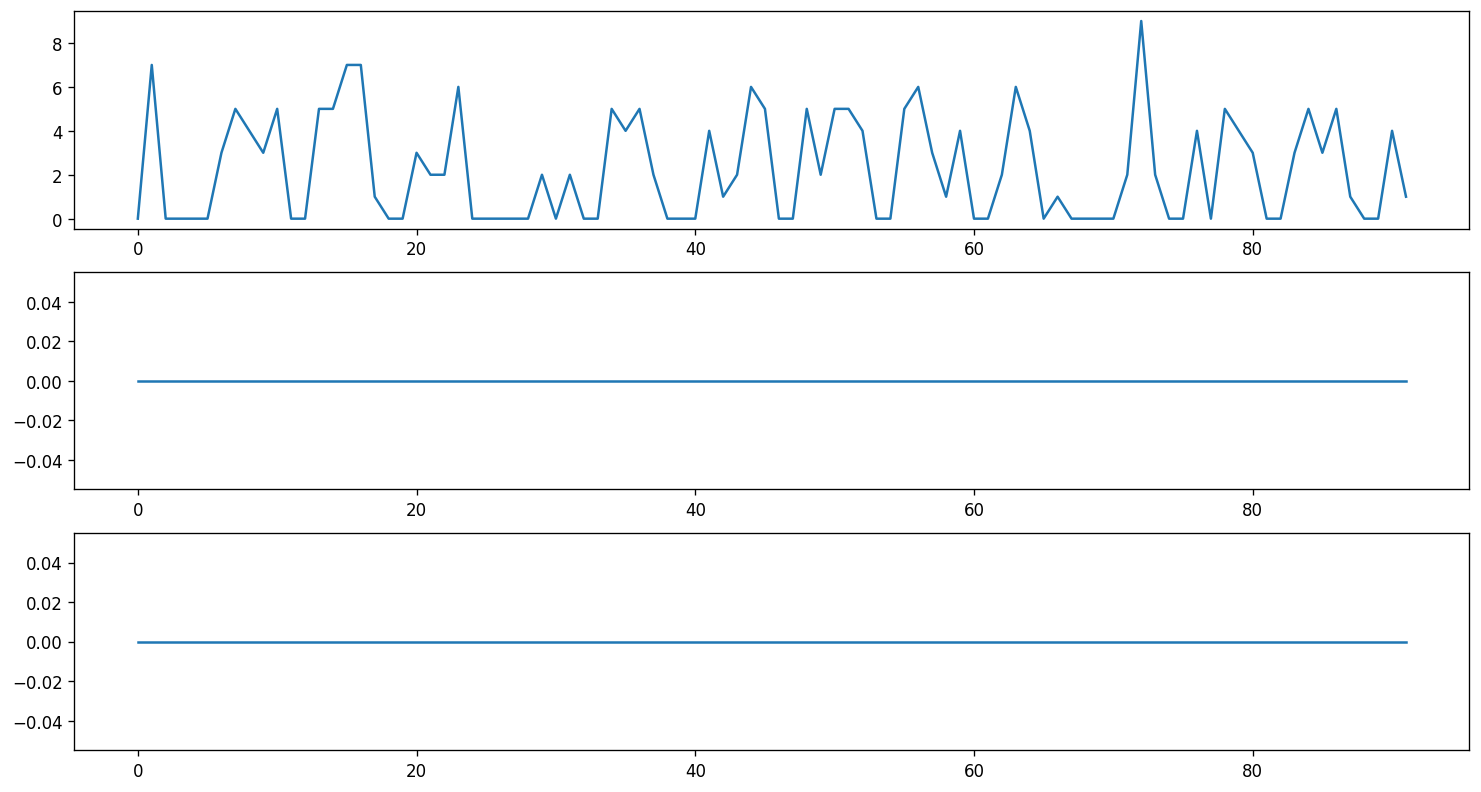

In [335]:
amostra = random.sample(TODAS_324_ODS,3)

fig, ax = plt.subplots(nrows=3, figsize = (15,8))

for aaa in range(len(amostra)):
    ax[aaa].plot(amostra[aaa])

Isso aqui significa quais dias tem mais de 324 viagens atraves das entradas da OD 

Ou seja, como se tivesse pelo menos uma viagem para cada OD, de fato sao pouquissimos dias, so 4

In [336]:

for i in range(92):

    if ODs_diarios[i].sum().sum() >=324:

        print(datetime(2021,6,1) + timedelta(days = i), '==================================================================')
        display(ODs_diarios[i])

2021-06-16 00:00:00 ==================================================================


1     5    6    8    9     10   13   15    17   18   20   21   22   23  \
1   0.0   2.0  2.0  0.0  1.0   3.0  0.0  0.0   4.0  0.0  5.0  2.0  1.0  7.0   
5   0.0   3.0  0.0  0.0  0.0   1.0  0.0  2.0   0.0  0.0  0.0  2.0  7.0  0.0   
6   0.0   0.0  0.0  0.0  3.0   1.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  1.0   
8   4.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  2.0  0.0  1.0  0.0   
9   0.0   1.0  3.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  1.0  0.0  0.0   
10  1.0   4.0  1.0  0.0  1.0   0.0  6.0  1.0  15.0  0.0  0.0  0.0  0.0  0.0   
13  3.0   0.0  0.0  3.0  0.0   2.0  0.0  0.0   4.0  0.0  0.0  0.0  0.0  0.0   
15  0.0   1.0  2.0  0.0  1.0   1.0  3.0  0.0   0.0  0.0  0.0  0.0  1.0  0.0   
17  3.0   6.0  0.0  2.0  0.0  10.0  9.0  0.0   7.0  0.0  0.0  1.0  0.0  0.0   
18  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
20  3.0   0.0  0.0  0.0  2.0   3.0  0.0  0.0   3.0  0.0  0.0  0.0  0.0  0.0   
21  2.0  30.0  0.0  0.0  0.0   0.0  0.0  1.0   0.0  0.0  0.0  3.0  0.0  0.0   
22  0.0   2.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  1.0  0.0  0.0  0.0  0.0   
23  2.0   2.0  1.0  0.0  2.0   0.0  0.0  1.0   0.0  0.0  0.0  0.0  0.0  0.0   
26  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
31  0.0   2.0  0.0  0.0  0.0   1.0  0.0  0.0   0.0  0.0  0.0  0.0  1.0  0.0   
32  3.0   0.0  2.0  4.0  0.0   1.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0   
33  0.0   0.0  0.0  0.0  0.0   5.0  8.0  0.0   2.0  0.0  0.0  0.0  0.0  0.0   

    26   31    32    33  
1    0  0.0   2.0   0.0  
5    0  2.0   0.0   0.0  
6    0  2.0   3.0   1.0  
8    0  0.0   0.0   0.0  
9    0  3.0   1.0   0.0  
10   0  4.0  12.0   7.0  
13   0  1.0   3.0   7.0  
15   0  2.0   0.0   0.0  
17   0  1.0   4.0   7.0  
18   0  0.0   0.0   1.0  
20   0  0.0   0.0   0.0  
21   0  0.0   0.0   0.0  
22   0  0.0   0.0   0.0  
23   0  0.0   0.0   0.0  
26   0  0.0   0.0   0.0  
31   0  0.0   0.0   0.0  
32   0  0.0   0.0   0.0  
33   0  1.0   2.0  29.0

2021-07-27 00:00:00 ==================================================================


1     5    6    8    9     10   13   15   17   18   20   21    22   23  \
1   0.0   3.0  2.0  0.0  4.0   7.0  0.0  1.0  3.0  1.0  3.0  2.0   0.0  5.0   
5   0.0   4.0  1.0  0.0  1.0   3.0  0.0  0.0  0.0  1.0  0.0  3.0  12.0  1.0   
6   0.0   7.0  0.0  0.0  2.0   0.0  1.0  0.0  2.0  0.0  0.0  0.0   0.0  0.0   
8   1.0   1.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  1.0   
9   0.0   1.0  1.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  1.0   1.0  0.0   
10  1.0   4.0  2.0  1.0  1.0   1.0  8.0  0.0  9.0  2.0  0.0  0.0   0.0  1.0   
13  0.0   0.0  0.0  0.0  0.0   4.0  2.0  0.0  6.0  0.0  0.0  0.0   0.0  0.0   
15  1.0   1.0  0.0  0.0  1.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   
17  1.0   2.0  0.0  1.0  0.0  20.0  6.0  0.0  2.0  0.0  0.0  0.0   0.0  1.0   
18  0.0   0.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   
20  3.0   0.0  0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  7.0   
21  2.0  25.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  2.0   0.0  0.0   
22  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  1.0  0.0  0.0   4.0  0.0   
23  4.0   9.0  1.0  0.0  0.0   0.0  0.0  1.0  0.0  0.0  1.0  0.0   1.0  2.0   
26  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   
31  1.0   1.0  0.0  0.0  0.0   2.0  0.0  0.0  0.0  0.0  0.0  0.0   2.0  0.0   
32  5.0   1.0  2.0  1.0  0.0   1.0  0.0  0.0  1.0  0.0  2.0  0.0   0.0  2.0   
33  0.0   1.0  0.0  0.0  1.0   4.0  5.0  1.0  3.0  0.0  0.0  0.0   0.0  0.0   

    26   31   32    33  
1    0  2.0  1.0   0.0  
5    0  4.0  0.0   0.0  
6    0  5.0  0.0   1.0  
8    0  0.0  0.0   0.0  
9    0  4.0  0.0   2.0  
10   0  1.0  9.0  12.0  
13   0  1.0  2.0   6.0  
15   0  2.0  0.0   0.0  
17   0  1.0  2.0   7.0  
18   0  0.0  0.0   0.0  
20   0  0.0  1.0   0.0  
21   0  0.0  0.0   0.0  
22   0  0.0  0.0   0.0  
23   0  1.0  0.0   0.0  
26   0  0.0  0.0   0.0  
31   0  0.0  0.0   0.0  
32   0  1.0  3.0   0.0  
33   0  1.0  0.0  33.0

2021-08-11 00:00:00 ==================================================================


1     5    6    8    9     10   13   15    17   18   20   21    22    23  \
1   0.0   3.0  1.0  0.0  0.0   6.0  1.0  3.0   3.0  1.0  3.0  0.0   1.0  10.0   
5   0.0   2.0  0.0  0.0  0.0   1.0  0.0  1.0   0.0  0.0  0.0  3.0  12.0   0.0   
6   0.0   3.0  0.0  0.0  1.0   3.0  0.0  0.0   1.0  0.0  0.0  0.0   0.0   0.0   
8   1.0   1.0  2.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0   
9   0.0   2.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0   
10  4.0   6.0  2.0  0.0  1.0   0.0  7.0  0.0  10.0  2.0  1.0  1.0   0.0   3.0   
13  0.0   1.0  0.0  1.0  0.0   6.0  1.0  0.0   5.0  0.0  0.0  0.0   0.0   0.0   
15  0.0   0.0  0.0  0.0  1.0   1.0  0.0  0.0   1.0  0.0  0.0  0.0   0.0   0.0   
17  0.0   1.0  1.0  0.0  0.0  15.0  8.0  0.0   2.0  0.0  0.0  1.0   0.0   0.0   
18  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0   
20  2.0   0.0  0.0  0.0  0.0   2.0  0.0  0.0   1.0  0.0  0.0  0.0   0.0   1.0   
21  0.0  35.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0   
22  0.0   0.0  0.0  0.0  0.0   1.0  0.0  0.0   0.0  2.0  0.0  0.0   1.0   0.0   
23  1.0   3.0  1.0  0.0  0.0   1.0  0.0  0.0   1.0  0.0  1.0  0.0   0.0   0.0   
26  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0   0.0   0.0   
31  0.0   1.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  1.0  0.0   0.0   0.0   
32  4.0   1.0  1.0  0.0  1.0   3.0  0.0  0.0   1.0  0.0  0.0  0.0   0.0   1.0   
33  0.0   0.0  0.0  0.0  1.0   1.0  6.0  1.0   4.0  5.0  0.0  0.0   0.0   0.0   

    26   31    32    33  
1    0  6.0   1.0   0.0  
5    0  4.0   0.0   0.0  
6    0  6.0   1.0   1.0  
8    0  0.0   0.0   1.0  
9    0  5.0   0.0   0.0  
10   0  5.0  13.0   4.0  
13   0  0.0   2.0   2.0  
15   0  4.0   0.0   0.0  
17   0  1.0   5.0   6.0  
18   0  0.0   0.0   2.0  
20   0  0.0   0.0   0.0  
21   0  0.0   0.0   0.0  
22   0  0.0   0.0   0.0  
23   0  0.0   0.0   0.0  
26   0  0.0   0.0   0.0  
31   0  0.0   0.0   0.0  
32   0  0.0   0.0   0.0  
33   0  1.0   1.0  27.0

2021-08-18 00:00:00 ==================================================================


1     5    6    8    9     10   13   15    17   18   20   21   22   23  \
1   0.0   2.0  1.0  0.0  2.0   5.0  0.0  3.0   0.0  2.0  2.0  0.0  2.0  2.0   
5   0.0   3.0  0.0  0.0  1.0   2.0  0.0  0.0   0.0  0.0  0.0  2.0  1.0  1.0   
6   0.0   1.0  0.0  0.0  6.0   7.0  0.0  0.0   0.0  0.0  0.0  2.0  1.0  0.0   
8   4.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0   2.0  0.0  1.0  0.0  0.0  0.0   
9   0.0   0.0  1.0  0.0  0.0   0.0  0.0  0.0   1.0  0.0  1.0  0.0  2.0  1.0   
10  2.0   4.0  2.0  2.0  1.0   0.0  8.0  0.0  16.0  0.0  1.0  0.0  1.0  2.0   
13  0.0   2.0  0.0  1.0  0.0   5.0  1.0  0.0   2.0  0.0  0.0  0.0  0.0  0.0   
15  4.0   0.0  1.0  0.0  1.0   1.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  1.0   
17  0.0   3.0  1.0  0.0  0.0  17.0  3.0  0.0   3.0  0.0  0.0  0.0  0.0  1.0   
18  0.0   0.0  0.0  0.0  0.0   3.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
20  1.0   0.0  1.0  0.0  0.0   0.0  0.0  0.0   1.0  0.0  0.0  0.0  0.0  1.0   
21  0.0  21.0  0.0  0.0  1.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
22  0.0   0.0  0.0  0.0  0.0   1.0  0.0  0.0   0.0  0.0  0.0  0.0  2.0  0.0   
23  5.0   1.0  1.0  0.0  1.0   0.0  0.0  1.0   0.0  0.0  1.0  0.0  1.0  1.0   
26  0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   
31  0.0   1.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0  0.0  0.0  1.0  3.0  0.0   
32  2.0   1.0  4.0  0.0  1.0   0.0  0.0  1.0   4.0  1.0  0.0  0.0  0.0  0.0   
33  1.0   1.0  0.0  2.0  1.0   3.0  9.0  0.0   6.0  1.0  0.0  0.0  0.0  0.0   

    26   31    32    33  
1    0  0.0   0.0   0.0  
5    0  6.0   0.0   0.0  
6    0  1.0   2.0   0.0  
8    0  2.0   0.0   2.0  
9    0  4.0   0.0   0.0  
10   0  2.0  14.0   9.0  
13   0  0.0   2.0   5.0  
15   0  0.0   0.0   0.0  
17   0  6.0   2.0   7.0  
18   0  0.0   0.0   1.0  
20   0  0.0   0.0   0.0  
21   0  0.0   0.0   0.0  
22   0  0.0   0.0   2.0  
23   0  0.0   0.0   0.0  
26   0  0.0   0.0   0.0  
31   0  0.0   0.0   1.0  
32   0  1.0   1.0   1.0  
33   0  0.0   0.0  28.0

<BarContainer object of 63 artists>

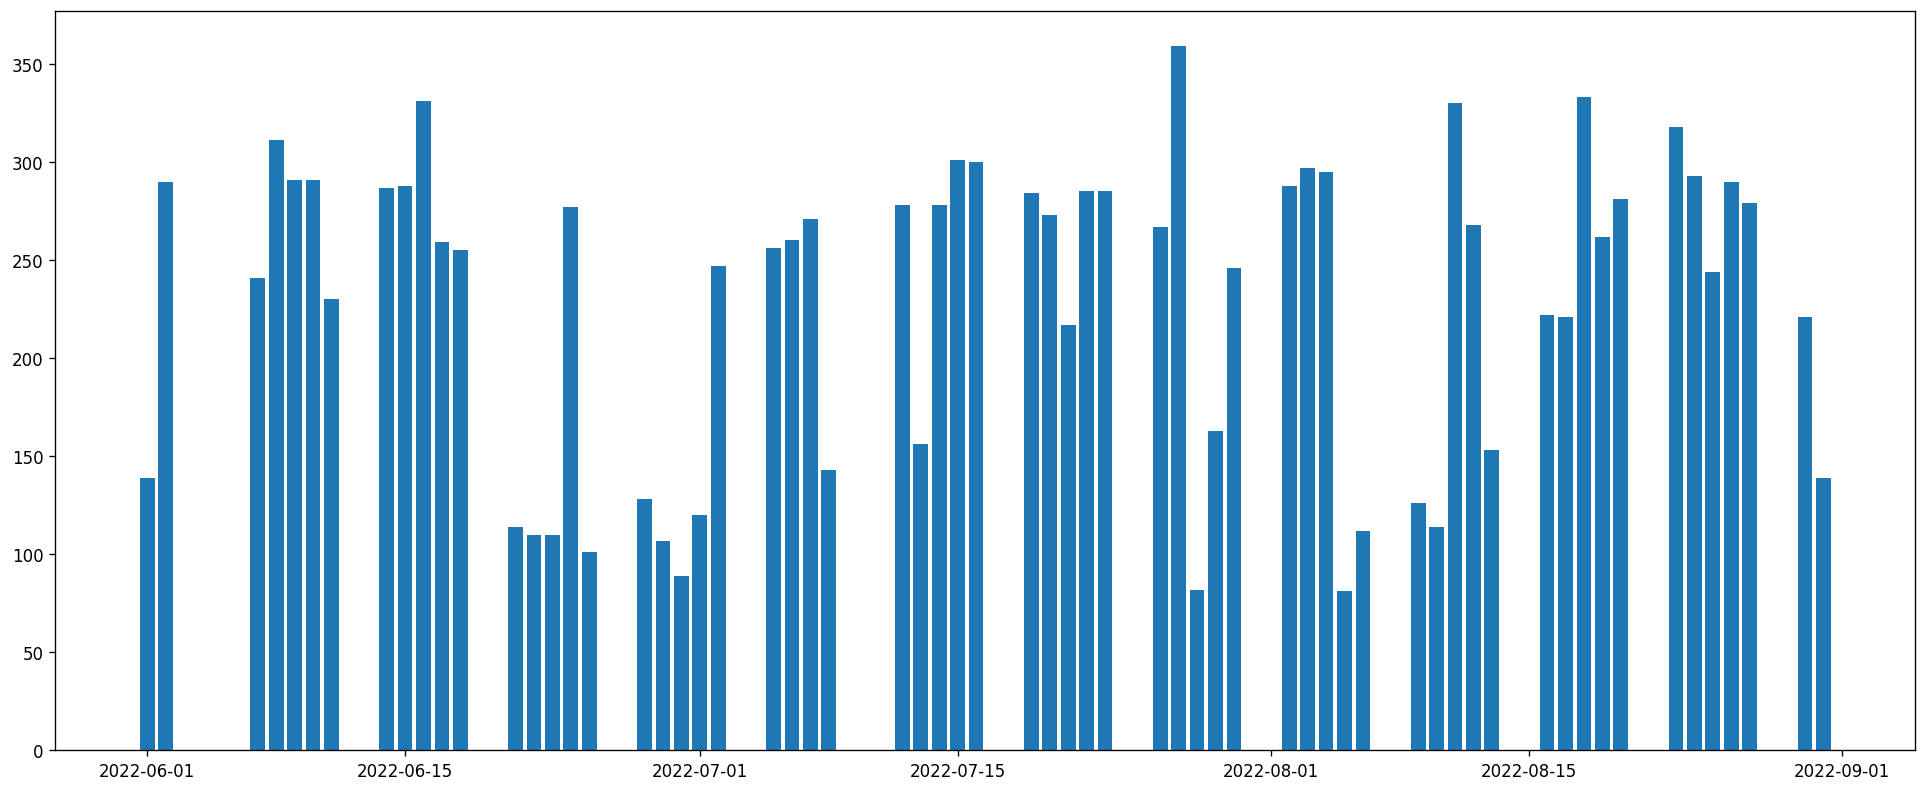

In [337]:
# volumes_totais_diarios['Volume'].plot(kind='bar', figsize = (15,8));
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(volumes_totais_diarios['Data'], volumes_totais_diarios['Volume'])